In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

from sklearn.metrics import (
    
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    balanced_accuracy_score, 
    classification_report,
    roc_auc_score,
    f1_score, 
    roc_curve
   
)

from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig

pd.options.mode.chained_assignment = None

with initialize(version_base=None, config_path="conf", job_name="test"):
    cfg = compose(config_name="config")
    print(OmegaConf.to_yaml(cfg))

random_seed: 0
work_dir: /work/robinpark
root_dir: ${work_dir}/AutoLabelClassifier
raw_dicom_folder: ${work_dir}/data-apr23/PID010A
clean_path: ${work_dir}/PID010A_clean
updated_clean_path: ${work_dir}/NCIMI_clean
unpaired_reports: /work/rhydian/ProcessedSpinalMRIReports/
model_weights_save_path: /scratch/shared/nfs2/robinpark/models
osc_reports: ${work_dir}/AutoLabelClassifier/data/osclmric_reports
patient_metadata: ${clean_path}/patient_metadata.csv
conclusion_training_data: ${clean_path}/segmented_unpaired_reports_sum_no_len_limit.csv
train_labeled_data: ${updated_clean_path}/ncimi_sampled_test_set_labeled.csv
labeled_data: ${updated_clean_path}/ncimi_sampled_train_set_labeled.csv
no_hist_labeled_data: ${updated_clean_path}/ncimi_sampled_train_set_labeled.csv
full_ncimi_data: ${updated_clean_path}/unique_reports.csv
seg_full_ncimi_data: ${updated_clean_path}/segmented_unique_reports.csv
osc_train_data: ${osc_reports}/osclmric_reports_labeled_train.csv
osc_test_data: ${osc_reports}/o

In [2]:
def norm_scores_yes(row):
    scores = torch.tensor([row['yes_score'], row['no_score']])
    return F.softmax(scores,dim=0)[0].item()

def norm_scores_no(row):
    scores = torch.tensor([row['yes_score'], row['no_score']])
    return F.softmax(scores,dim=0)[1].item()

In [3]:
li_results = []

In [4]:
def eval_global(model, desc, filepath, threshold=None):

    data_path = '/work/robinpark/AutoLabelClassifier/data'

    folder = f'{data_path}/report_labels'

    # Import results
    df_results = pd.read_csv(f'{folder}/{filepath}.csv', index_col=0).reset_index(drop=True)
    if 'labels' in df_results.columns:
        df_results = df_results.drop(columns=['labels'])

    if filepath.find('gpt') > -1:
        df_results.loc[df_results['results'].str.lower().str.find('uncertain') > -1, 'results'] = 0
        df_results.loc[df_results['results'].str.lower().str.find('yes') > -1, 'results'] = 1 
        df_results.loc[df_results['results'].str.lower().str.find('no') > -1, 'results'] = 0 
        df_results['results'] = df_results['results'].astype(int)

    if filepath.find('cancer') > -1:
        if filepath.find('cancer_TRAIN') > -1:
            df_true_labels = pd.read_csv(cfg.train_labeled_data, index_col=0).reset_index(drop=True)
        else:
            df_true_labels = pd.read_csv(cfg.labeled_data, index_col=0).reset_index(drop=True)
        df_results = df_results.merge(df_true_labels,left_index=True, right_index=True, how='left')
        df_results = df_results.rename(columns={'label':'labels'})
        display_labels = ['No Cancer','Cancer']
    
    if filepath.find('stenosis') > -1:
        if filepath.find('stenosis_TRAIN') > -1:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/osclmric_reports_labeled_train.csv', index_col=0).reset_index(drop=True)
        else:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/osclmric_reports_labeled_test.csv', index_col=0).reset_index(drop=True)
        df_results = df_results.merge(df_true_labels,left_index=True, right_index=True, how='left')
        df_results = df_results.loc[df_results.result > -1]
        df_results = df_results.rename(columns={'result':'labels'})
        display_labels = ['No Stenosis','Stenosis']

    if filepath.find('cauda_equina') > -1: 
        if filepath.find('cauda_equina_train') > -1:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/manually_labeled_cauda_equina_train.csv', index_col=0).reset_index(drop=True)
        else:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/manually_labeled_cauda_equina_test.csv', index_col=0).reset_index(drop=True)
        df_results = df_results.merge(df_true_labels,left_index=True, right_index=True, how='left')
        df_results = df_results.loc[df_results.global_label > -1]
        df_results = df_results.rename(columns={'global_label':'labels'})
        display_labels = ['No Cauda Equina','Cauda Equina']

    if filepath.find('herniation') > -1: 
        if filepath.find('herniation_train') > -1:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/herniation_reports_labeled_train.csv', index_col=0).reset_index(drop=True)
        else:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/herniation_reports_labeled_test.csv', index_col=0).reset_index(drop=True)
        df_results = df_results.merge(df_true_labels,left_index=True, right_index=True, how='left')
        df_results = df_results.loc[df_results.global_label > -1]
        df_results = df_results.rename(columns={'global_label':'labels'})
        display_labels = ['No Herniation','Herniation']


    labels = df_results['labels']
    pred = df_results['results']

    roc_auc = '-'

    if model != 'gpt4':
        df_results['yes_norm'] = df_results.apply(lambda x: norm_scores_yes(x), axis=1)
        df_results['no_norm'] = df_results.apply(lambda x: norm_scores_no(x), axis=1)
        scores = df_results['yes_norm']

        if threshold:
            pred = df_results['yes_norm'] > threshold

        roc_auc = roc_auc_score(labels, scores)
        print(f'ROC AUC: {roc_auc}')

        fpr, tpr, threshold = roc_curve(labels, scores)
        fnr = 1 - tpr
        eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
        eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

        print(f'EER threshold: {eer_threshold}')
        print(f'EER: {eer}')

    else:
        eer = '-'
    
    balanced_acc = balanced_accuracy_score(labels, pred)
    print(f'Balanced accuracy: {balanced_acc}')

    f1 = f1_score(labels, pred)
    print(f'F1 score: {f1}')

    class_report = classification_report(labels, pred, target_names=display_labels)
    conf_mat = confusion_matrix(labels, pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                display_labels=display_labels)

    print(class_report)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    if desc.find('test') > -1:
        li_results.append(
            {'model': model, 'desc': desc, 
            'balanced_accuracy': balanced_acc,
            'eer': eer,
            'auroc': roc_auc,
            'f1_score': f1}
        ) 
    
    return df_results

In [5]:
li_level_results = []

In [6]:
def eval_level(data, level, threshold=None): 

    label_path = '/work/robinpark/AutoLabelClassifier/data/report_labels/april2024/summary-query/base-base'
    root_path = '/work/robinpark/AutoLabelClassifier'

    display_labels = ['No Stenosis','Stenosis']

    level_rp = level.replace('-','')

    if data.find('stenosis') > -1:
        df_level = pd.read_csv(f'{label_path}/llama3_base_2step_{data}{level_rp}_new_template_yesno_scores_have_spec_summary_prompt.csv')
        df_newlabels = pd.read_csv(f'{root_path}/data/osclmric_reports/OSCLMRIC_reports_stenosis_by_ivd.csv')
        df_results = df_level.merge(df_newlabels, left_on='report_no_hist', right_on='Report', how='left')
        condition='stenosis'
    elif data.find('cauda_equina') > -1: 
        df_level = pd.read_csv(f'{label_path}/llama3_base_2step_{data}{level_rp}_new_template_yesno_scores_have_spec_summary_prompt.csv')
        condition='cauda_equina'
        if data.find('cauda_equina_train') > -1: 
            df_newlabels = pd.read_csv(f'{root_path}/data/osclmric_reports/manually_labeled_cauda_equina_train.csv')
        elif data.find('cauda_equina_test') > -1:
            df_newlabels = pd.read_csv(f'{root_path}/data/osclmric_reports/manually_labeled_cauda_equina_test.csv')
        df_results = df_level.merge(df_newlabels, left_on='report_no_hist', right_on='report', how='left')
    elif data.find('herniation') > -1: 
        df_level = pd.read_csv(f'{label_path}/llama3_base_2step_{data}{level_rp}_new_template_yesno_scores_have_spec_summary_prompt.csv')
        condition='herniation'
        if data.find('herniation_train') > -1: 
            df_newlabels = pd.read_csv(f'{root_path}/data/osclmric_reports/herniation_reports_labeled_train.csv')
        elif data.find('herniation_test') > -1:
            df_newlabels = pd.read_csv(f'{root_path}/data/osclmric_reports/herniation_reports_labeled_test.csv')
        df_results = df_level.merge(df_newlabels, left_on='report_no_hist', right_on='report', how='left')
        df_results = df_results.loc[df_results[level]>-1]
    
    df_results['labels'] = df_results[level].fillna(0)

    df_results['yes_norm'] = df_results.apply(lambda x: norm_scores_yes(x), axis=1)
    df_results['no_norm'] = df_results.apply(lambda x: norm_scores_no(x), axis=1)

    labels = df_results['labels']
    scores = df_results['yes_norm']
    pred = df_results['results']

    if threshold:
        pred = df_results['yes_norm'] > threshold
        
    roc_auc = roc_auc_score(labels, scores)
    print(f'ROC AUC: {roc_auc}')

    balanced_acc = balanced_accuracy_score(labels, pred)
    print(f'Balanced accuracy: {balanced_acc}')

    f1 = f1_score(labels, pred)
    print(f'F1 score: {f1}')

    fpr, tpr, threshold = roc_curve(labels, scores)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
    eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    test = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    print(f'EER threshold: {eer_threshold}')
    print(f'EER: {eer}')

    class_report = classification_report(labels, pred, target_names=display_labels)
    conf_mat = confusion_matrix(labels, pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                display_labels=display_labels)

    print(class_report)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    if (data.find('TRAIN') > -1) | (data.find('cauda_equina_test') > -1) | (data.find('herniation_test') > -1):
        li_level_results.append(
            {'condition': condition,
            'level': level, 
            'balanced_accuracy': balanced_acc,
            'eer': eer,
            'auroc': roc_auc,
            'f1_score': f1}
        ) 

    return df_results

## Global Results per Report

### GPT-4 Baseline

Balanced accuracy: 1.0
F1 score: 1.0
              precision    recall  f1-score   support

   No Cancer       1.00      1.00      1.00        78
      Cancer       1.00      1.00      1.00        67

    accuracy                           1.00       145
   macro avg       1.00      1.00      1.00       145
weighted avg       1.00      1.00      1.00       145



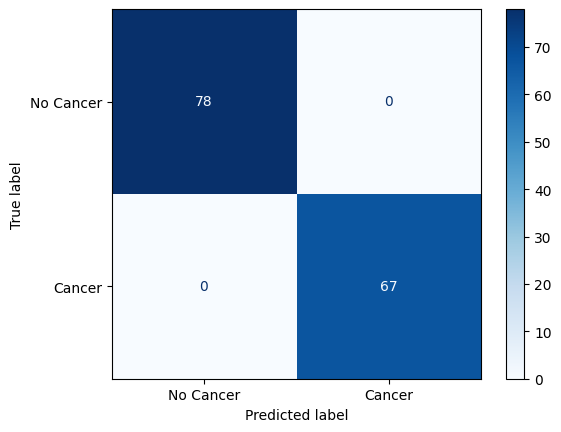

In [7]:
gpt_cancer_1step_test = eval_global(
    'gpt4', 
    'direct-query-cancer-test',
    'april2024/direct-query/gpt4_cancer_TRAIN_new_have_prompt', 
    threshold=None)    

Balanced accuracy: 0.9512195121951219
F1 score: 0.9487179487179488
              precision    recall  f1-score   support

 No Stenosis       0.87      1.00      0.93        27
    Stenosis       1.00      0.90      0.95        41

    accuracy                           0.94        68
   macro avg       0.94      0.95      0.94        68
weighted avg       0.95      0.94      0.94        68



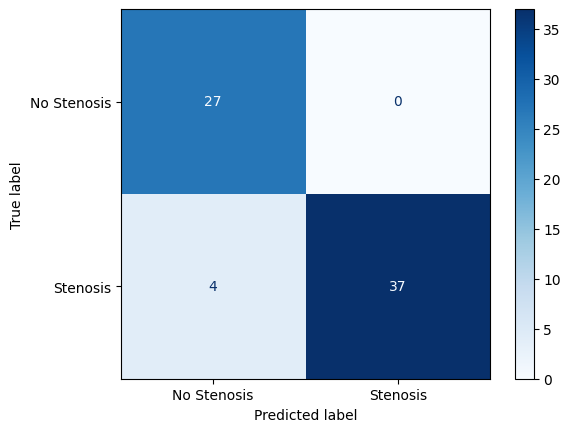

In [8]:
gpt_stenosis_1step_test = eval_global(
    'gpt4', 
    'direct-query-stenosis-test',
    'direct-query/gpt4_stenosis_TRAIN_new_have_prompt', 
    threshold=None)    

Balanced accuracy: 0.9705882352941176
F1 score: 0.9696969696969697
                 precision    recall  f1-score   support

No Cauda Equina       0.99      1.00      0.99        77
   Cauda Equina       1.00      0.94      0.97        17

       accuracy                           0.99        94
      macro avg       0.99      0.97      0.98        94
   weighted avg       0.99      0.99      0.99        94



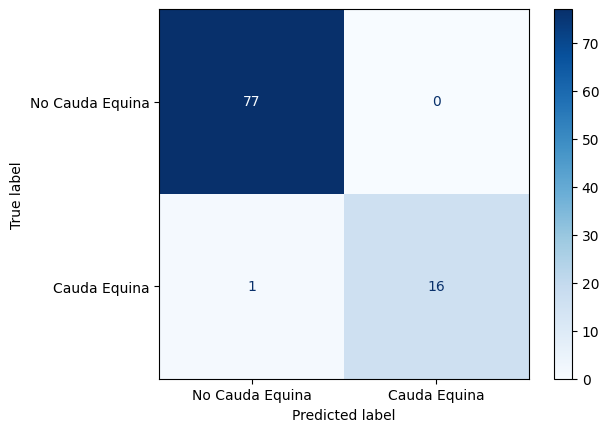

In [9]:
gpt_ce_1step_test = eval_global(
    'gpt4', 
    'direct-query-cauda-equina-test',
    'april2024/direct-query/gpt4_cauda_equina_test_new_have_prompt', 
    threshold=None)    

Balanced accuracy: 0.7142857142857143
F1 score: 0.7000000000000001
               precision    recall  f1-score   support

No Herniation       1.00      0.43      0.60        42
   Herniation       0.54      1.00      0.70        28

     accuracy                           0.66        70
    macro avg       0.77      0.71      0.65        70
 weighted avg       0.82      0.66      0.64        70



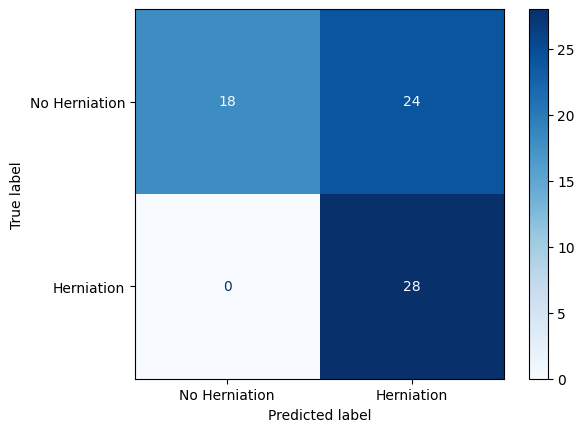

In [10]:
gpt_hern_1step_test = eval_global(
    'gpt4', 
    'direct-query-herniation-test',
    'april2024/direct-query/gpt4_herniation_test_new_have_prompt', 
    threshold=None)    

### One-Step Query

#### Zephyr

ROC AUC: 0.9934573706808424
EER threshold: 0.0002891702461056411
EER: 0.0136986301369863
Balanced accuracy: 0.9632999386628501
F1 score: 0.9618320610687023
              precision    recall  f1-score   support

   No Cancer       0.95      0.99      0.97        73
      Cancer       0.98      0.94      0.96        67

    accuracy                           0.96       140
   macro avg       0.97      0.96      0.96       140
weighted avg       0.97      0.96      0.96       140



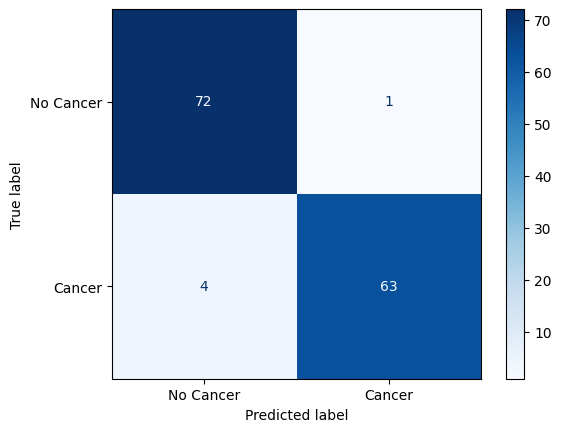

In [11]:
zephyr_1step_cancer_train = eval_global(
    'zephyr', 
    'direct-query-cancer-train', 
    'april2024/direct-query/zephyr_base_1step_cancer_new_template_yesno_scores_have_prompt', 
    threshold=None
    )

ROC AUC: 1.0
EER threshold: 5.4455751524074e-05
EER: 0.0
Balanced accuracy: 0.9925373134328358
F1 score: 0.9924812030075187
              precision    recall  f1-score   support

   No Cancer       0.99      1.00      0.99        78
      Cancer       1.00      0.99      0.99        67

    accuracy                           0.99       145
   macro avg       0.99      0.99      0.99       145
weighted avg       0.99      0.99      0.99       145



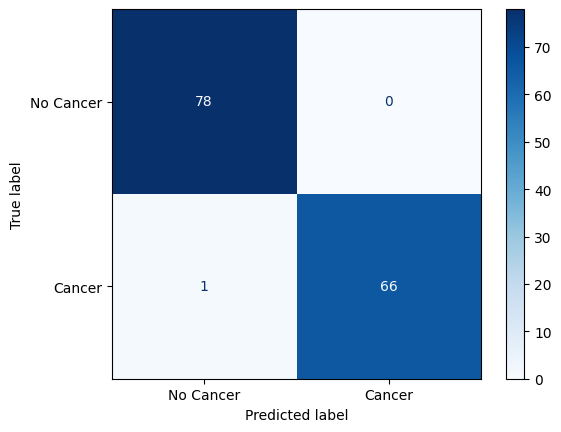

In [12]:
zephyr_1step_cancer_test = eval_global(
    'zephyr', 
    'direct-query-cancer-test', 
    'april2024/direct-query/zephyr_base_1step_cancer_TRAIN_new_template_yesno_scores_have_prompt', 
    threshold=0.0002891702461056411
    )

ROC AUC: 0.9565217391304348
EER threshold: 2.4696184482309036e-05
EER: 0.08695652173913043
Balanced accuracy: 0.8338164251207729
F1 score: 0.8205128205128205
              precision    recall  f1-score   support

 No Stenosis       0.63      0.96      0.76        23
    Stenosis       0.97      0.71      0.82        45

    accuracy                           0.79        68
   macro avg       0.80      0.83      0.79        68
weighted avg       0.85      0.79      0.80        68



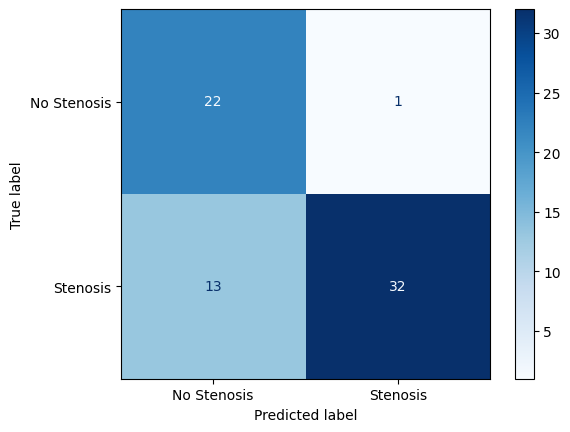

In [13]:
zephyr_1step_stenosis_train = eval_global(
    'zephyr', 
    'direct-query-stenosis-train',
    'april2024/direct-query/zephyr_base_1step_stenosis_new_template_yesno_scores_have_prompt', 
    threshold=None
    )

ROC AUC: 0.981029810298103
EER threshold: 2.619749238874647e-06
EER: 0.037037037037037035
Balanced accuracy: 0.9448961156278229
F1 score: 0.9500000000000001
              precision    recall  f1-score   support

 No Stenosis       0.90      0.96      0.93        27
    Stenosis       0.97      0.93      0.95        41

    accuracy                           0.94        68
   macro avg       0.94      0.94      0.94        68
weighted avg       0.94      0.94      0.94        68



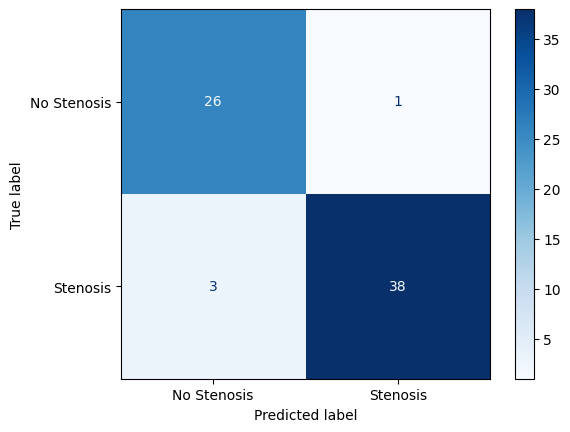

In [14]:
zephyr_1step_stenosis_test = eval_global(
    'zephyr', 
    'direct-query-stenosis-test',
    'april2024/direct-query/zephyr_base_1step_stenosis_TRAIN_new_template_yesno_scores_have_prompt', 
    threshold=2.4696184482309036e-05
    )

ROC AUC: 0.9901315789473684
EER threshold: 0.7071375250816345
EER: 0.013157894736842105
Balanced accuracy: 0.993421052631579
F1 score: 0.972972972972973
                 precision    recall  f1-score   support

No Cauda Equina       1.00      0.99      0.99        76
   Cauda Equina       0.95      1.00      0.97        18

       accuracy                           0.99        94
      macro avg       0.97      0.99      0.98        94
   weighted avg       0.99      0.99      0.99        94



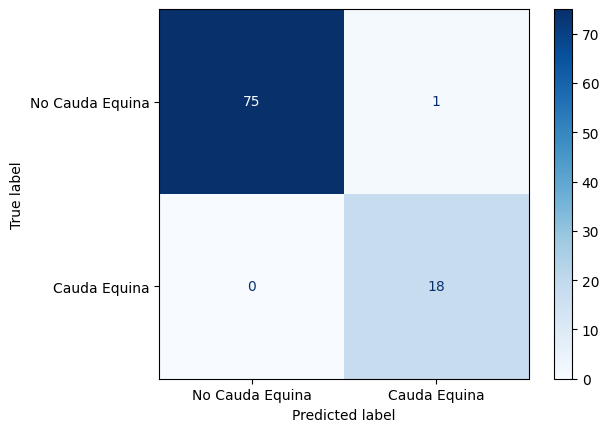

In [15]:
zephyr_1step_ce_train = eval_global(
    'zephyr', 
    'direct-query-cauda-equina-train',
    'april2024/direct-query/zephyr_base_1step_cauda_equina_train_new_template_yesno_scores_have_prompt', 
    threshold=None
    )

ROC AUC: 0.9977081741787623
EER threshold: 0.00015484055620618165
EER: 0.03896103896103896
Balanced accuracy: 0.9411764705882353
F1 score: 0.9375
                 precision    recall  f1-score   support

No Cauda Equina       0.97      1.00      0.99        77
   Cauda Equina       1.00      0.88      0.94        17

       accuracy                           0.98        94
      macro avg       0.99      0.94      0.96        94
   weighted avg       0.98      0.98      0.98        94



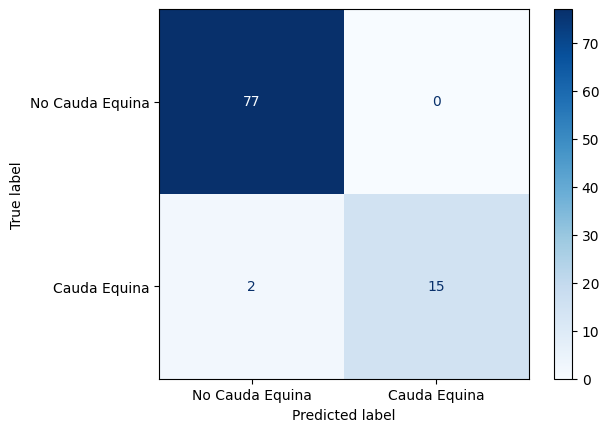

In [16]:
zephyr_1step_ce_test = eval_global(
    'zephyr', 
    'direct-query-cauda-equina-test',
    'april2024/direct-query/zephyr_base_1step_cauda_equina_test_new_template_yesno_scores_have_prompt', 
    threshold=0.7071375250816345
    )

ROC AUC: 0.8626700680272108
EER threshold: 0.9997677206993103
EER: 0.21428571428571427
Balanced accuracy: 0.7857142857142858
F1 score: 0.7536231884057972
               precision    recall  f1-score   support

No Herniation       0.93      0.64      0.76        42
   Herniation       0.63      0.93      0.75        28

     accuracy                           0.76        70
    macro avg       0.78      0.79      0.76        70
 weighted avg       0.81      0.76      0.76        70



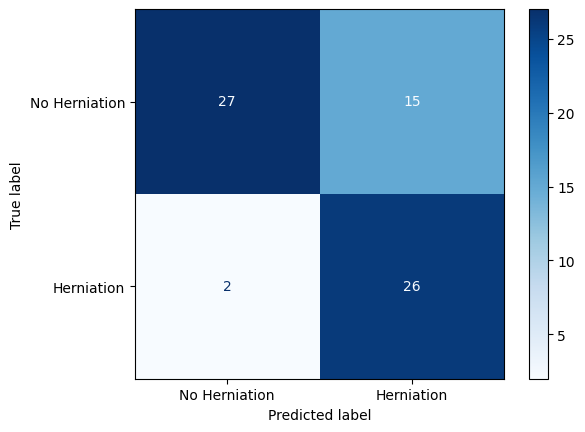

In [17]:
zephyr_1step_hern_train = eval_global(
    'zephyr', 
    'direct-query-hern-train',
    'april2024/direct-query/zephyr_base_1step_herniation_train_new_template_yesno_scores_have_prompt', 
    threshold=None
    )

ROC AUC: 0.9243197278911564
EER threshold: 0.9997519850730896
EER: 0.11904761904761904
Balanced accuracy: 0.8511904761904762
F1 score: 0.8214285714285714
               precision    recall  f1-score   support

No Herniation       0.88      0.88      0.88        42
   Herniation       0.82      0.82      0.82        28

     accuracy                           0.86        70
    macro avg       0.85      0.85      0.85        70
 weighted avg       0.86      0.86      0.86        70



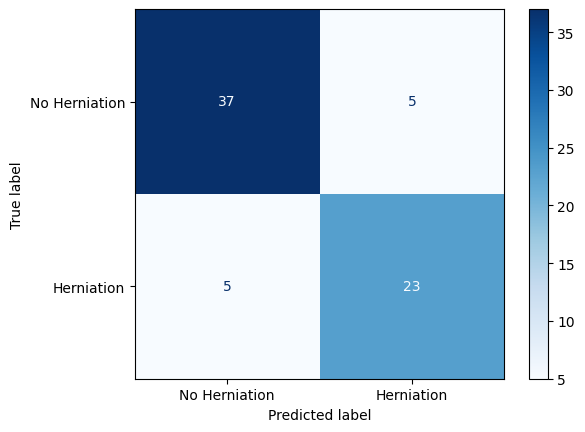

In [18]:
zephyr_1step_hern_test = eval_global(
    'zephyr', 
    'direct-query-hern-test',
    'april2024/direct-query/zephyr_base_1step_herniation_test_new_template_yesno_scores_have_prompt', 
    threshold=0.9997677206993103
    )

#### Llama3

ROC AUC: 0.998773257002658
EER threshold: 0.9889054298400879
EER: 0.0136986301369863
Balanced accuracy: 0.9719893682273564
F1 score: 0.9705882352941176
              precision    recall  f1-score   support

   No Cancer       0.99      0.96      0.97        73
      Cancer       0.96      0.99      0.97        67

    accuracy                           0.97       140
   macro avg       0.97      0.97      0.97       140
weighted avg       0.97      0.97      0.97       140



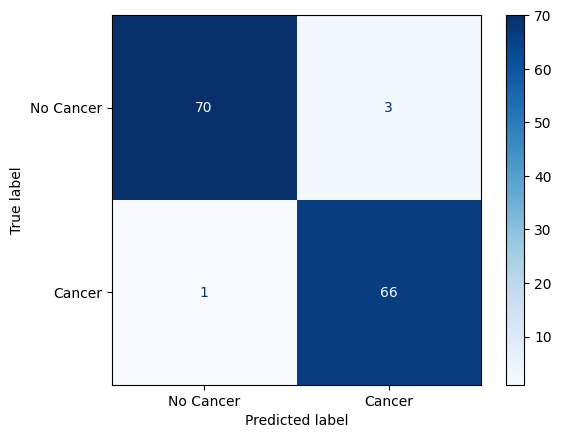

In [19]:
llama3_1step_cancer_train = eval_global(
    'llama3', 
    'direct-query-cancer-train', 
    'april2024/direct-query/llama3_base_1step_cancer_new_template_yesno_scores_have_prompt', 
    threshold=None
    )

ROC AUC: 0.998773257002658
EER threshold: 0.9889054298400879
EER: 0.0136986301369863
Balanced accuracy: 0.9782253117971784
F1 score: 0.9774436090225564
              precision    recall  f1-score   support

   No Cancer       0.97      0.99      0.98        73
      Cancer       0.98      0.97      0.98        67

    accuracy                           0.98       140
   macro avg       0.98      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140



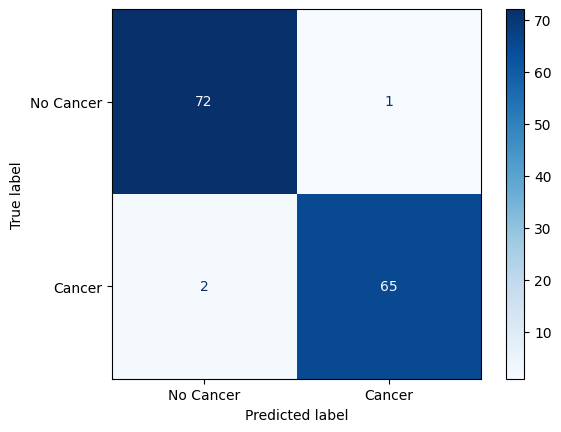

In [20]:
llama3_1step_cancer_test = eval_global(
    'llama3', 
    'direct-query-cancer-test', 
    'april2024/direct-query/llama3_base_1step_cancer_new_template_yesno_scores_have_prompt', 
    threshold=0.9889054298400879
    )

ROC AUC: 0.9845410628019323
EER threshold: 0.9768972396850586
EER: 0.0
Balanced accuracy: 0.9014492753623189
F1 score: 0.9333333333333333
              precision    recall  f1-score   support

 No Stenosis       0.87      0.87      0.87        23
    Stenosis       0.93      0.93      0.93        45

    accuracy                           0.91        68
   macro avg       0.90      0.90      0.90        68
weighted avg       0.91      0.91      0.91        68



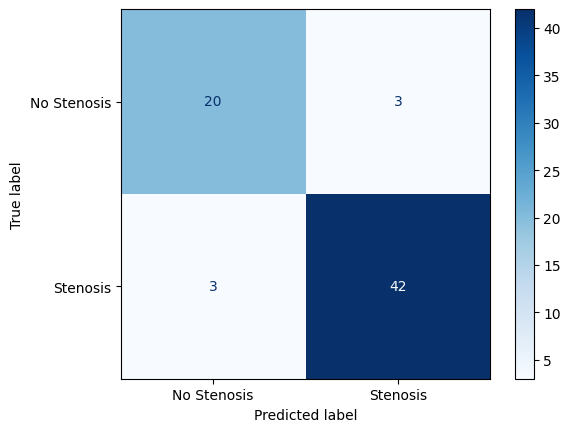

In [21]:
llama3_1step_stenosis_train = eval_global(
    'llama3', 
    'direct-query-stenosis-train', 
    'april2024/direct-query/llama3_base_1step_stenosis_new_template_yesno_scores_have_prompt', 
    threshold=None
    )

ROC AUC: 0.987353206865402
EER threshold: 0.9791182279586792
EER: 0.0
Balanced accuracy: 0.9634146341463414
F1 score: 0.9620253164556963
              precision    recall  f1-score   support

 No Stenosis       0.90      1.00      0.95        27
    Stenosis       1.00      0.93      0.96        41

    accuracy                           0.96        68
   macro avg       0.95      0.96      0.95        68
weighted avg       0.96      0.96      0.96        68



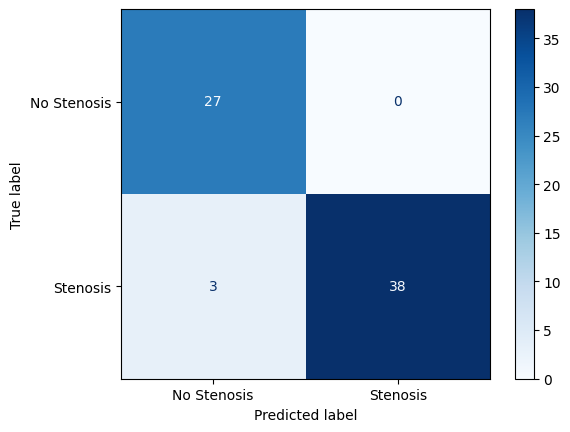

In [22]:
llama3_1step_stenosis_test = eval_global(
    'llama3', 
    'direct-query-stenosis-test', 
    'april2024/direct-query/llama3_base_1step_stenosis_TRAIN_new_template_yesno_scores_have_prompt', 
    threshold=0.9768972396850586
    )

ROC AUC: 0.9912280701754387
EER threshold: 0.9998121857643127
EER: 0.013157894736842105
Balanced accuracy: 0.9736842105263157
F1 score: 0.9
                 precision    recall  f1-score   support

No Cauda Equina       1.00      0.95      0.97        76
   Cauda Equina       0.82      1.00      0.90        18

       accuracy                           0.96        94
      macro avg       0.91      0.97      0.94        94
   weighted avg       0.97      0.96      0.96        94



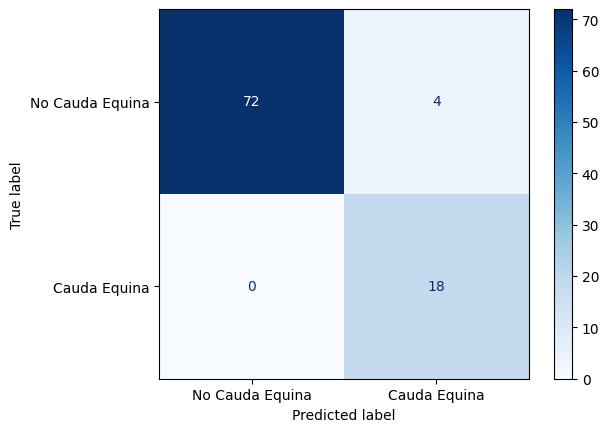

In [23]:
llama3_1step_ce_train = eval_global(
    'llama3', 
    'direct-query-cauda-equina-train',
    'april2024/direct-query/llama3_base_1step_cauda_equina_train_new_template_yesno_scores_have_prompt', 
    threshold=None
    )

ROC AUC: 0.998472116119175
EER threshold: 0.9984298348426819
EER: 0.025974025974025976
Balanced accuracy: 0.9705882352941176
F1 score: 0.9696969696969697
                 precision    recall  f1-score   support

No Cauda Equina       0.99      1.00      0.99        77
   Cauda Equina       1.00      0.94      0.97        17

       accuracy                           0.99        94
      macro avg       0.99      0.97      0.98        94
   weighted avg       0.99      0.99      0.99        94



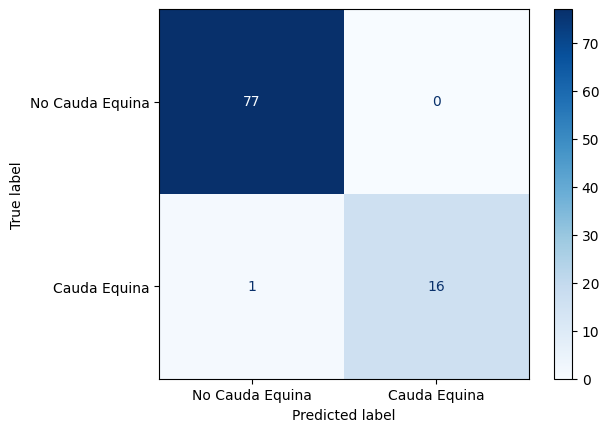

In [24]:
llama3_1step_ce_test = eval_global(
    'llama3', 
    'direct-query-cauda-equina-test',
    'april2024/direct-query/llama3_base_1step_cauda_equina_test_new_template_yesno_scores_have_prompt', 
    threshold=0.9998121857643127
    )

ROC AUC: 0.9370748299319728
EER threshold: 0.999985933303833
EER: 0.09523809523809523
Balanced accuracy: 0.6666666666666666
F1 score: 0.6666666666666666
               precision    recall  f1-score   support

No Herniation       1.00      0.33      0.50        42
   Herniation       0.50      1.00      0.67        28

     accuracy                           0.60        70
    macro avg       0.75      0.67      0.58        70
 weighted avg       0.80      0.60      0.57        70



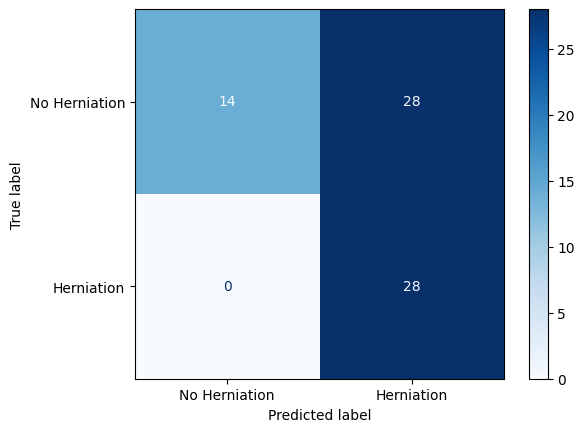

In [25]:
llama3_1step_hern_train = eval_global(
    'llama3', 
    'direct-query-hern-train',
    'april2024/direct-query/llama3_base_1step_herniation_train_new_template_yesno_scores_have_prompt'
    )

ROC AUC: 0.9370748299319728
EER threshold: 0.999985933303833
EER: 0.09523809523809523
Balanced accuracy: 0.8809523809523809
F1 score: 0.8571428571428571
               precision    recall  f1-score   support

No Herniation       0.90      0.90      0.90        42
   Herniation       0.86      0.86      0.86        28

     accuracy                           0.89        70
    macro avg       0.88      0.88      0.88        70
 weighted avg       0.89      0.89      0.89        70



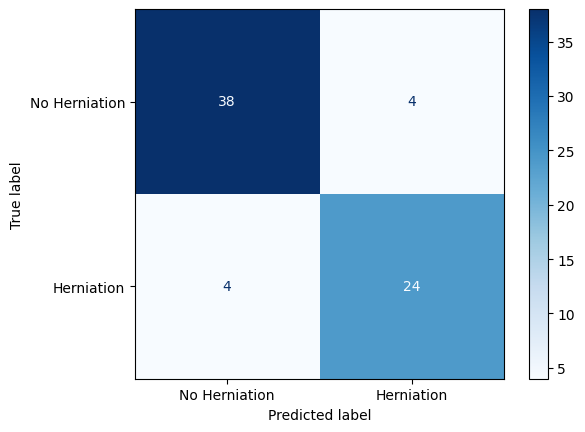

In [26]:
llama3_1step_hern_test = eval_global(
    'llama3', 
    'direct-query-hern-test',
    'april2024/direct-query/llama3_base_1step_herniation_train_new_template_yesno_scores_have_prompt',
    threshold=0.999985933303833
    )

### Two-Step Query: Base Zephyr

ROC AUC: 0.9854835411981189
EER threshold: 0.011947063729166985
EER: 0.0136986301369863
Balanced accuracy: 0.9632999386628501
F1 score: 0.9618320610687023
              precision    recall  f1-score   support

   No Cancer       0.95      0.99      0.97        73
      Cancer       0.98      0.94      0.96        67

    accuracy                           0.96       140
   macro avg       0.97      0.96      0.96       140
weighted avg       0.97      0.96      0.96       140



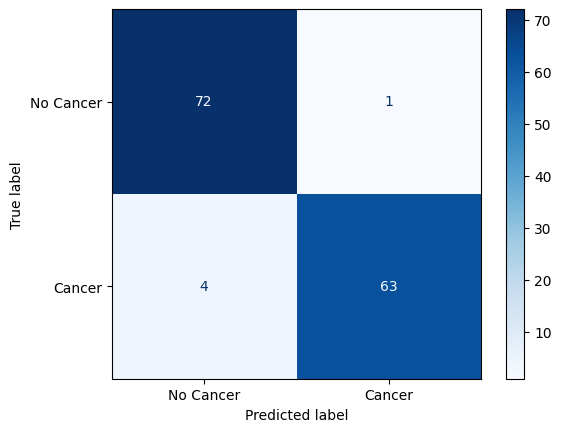

In [27]:
zephyr_2step_cancer_train = eval_global(
    'zephyr', 
    'base-base-cancer-train', 
    'april2024/summary-query/base-base/zephyr_base_2step_cancer_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 1.0
EER threshold: 5.4761545470682904e-05
EER: 0.0
Balanced accuracy: 0.9850746268656716
F1 score: 0.9848484848484849
              precision    recall  f1-score   support

   No Cancer       0.97      1.00      0.99        78
      Cancer       1.00      0.97      0.98        67

    accuracy                           0.99       145
   macro avg       0.99      0.99      0.99       145
weighted avg       0.99      0.99      0.99       145



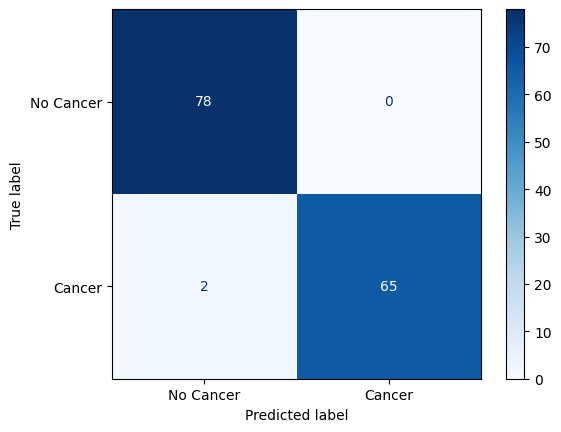

In [28]:
zephyr_2step_cancer_test = eval_global(
    'zephyr', 
    'base-base-cancer-test', 
    'april2024/summary-query/base-base/zephyr_base_2step_cancer_TRAIN_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.011947063729166985
    )

ROC AUC: 0.9111111111111111
EER threshold: 5.609211761736788e-09
EER: 0.08695652173913043
Balanced accuracy: 0.844927536231884
F1 score: 0.8354430379746834
              precision    recall  f1-score   support

 No Stenosis       0.65      0.96      0.77        23
    Stenosis       0.97      0.73      0.84        45

    accuracy                           0.81        68
   macro avg       0.81      0.84      0.80        68
weighted avg       0.86      0.81      0.81        68



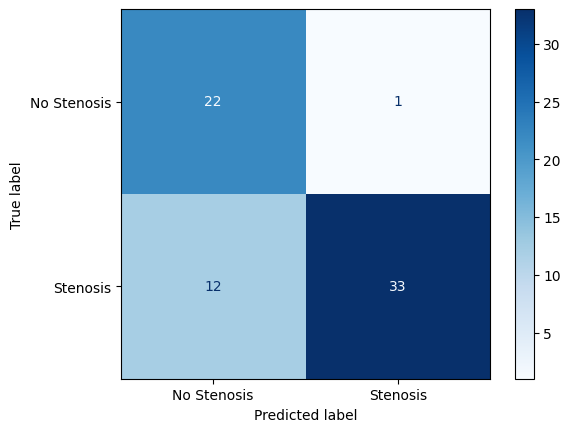

In [29]:
zephyr_2step_stenosis_train = eval_global(
    'zephyr', 
    'base-base-stenosis-train', 
    'april2024/summary-query/base-base/zephyr_base_2step_stenosis_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.9846431797651309
EER threshold: 2.810848886980466e-09
EER: 0.1111111111111111
Balanced accuracy: 0.9448961156278229
F1 score: 0.9500000000000001
              precision    recall  f1-score   support

 No Stenosis       0.90      0.96      0.93        27
    Stenosis       0.97      0.93      0.95        41

    accuracy                           0.94        68
   macro avg       0.94      0.94      0.94        68
weighted avg       0.94      0.94      0.94        68



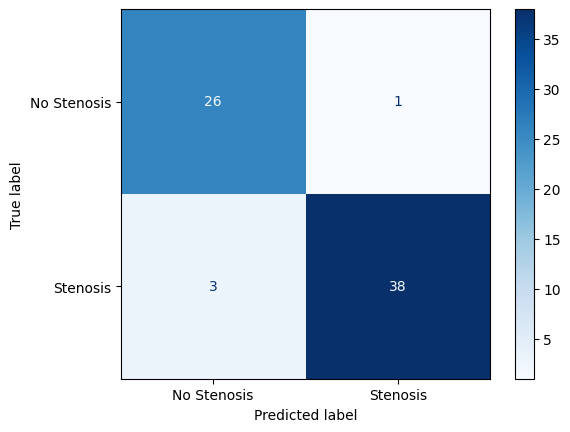

In [30]:
zephyr_2step_stenosis_test = eval_global(
    'zephyr', 
    'base-base-stenosis-test', 
    'april2024/summary-query/base-base/zephyr_base_2step_stenosis_TRAIN_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=5.609211761736788e-09
    )

ROC AUC: 0.991593567251462
EER threshold: 0.9955007433891296
EER: 0.013157894736842105
Balanced accuracy: 0.993421052631579
F1 score: 0.972972972972973
                 precision    recall  f1-score   support

No Cauda Equina       1.00      0.99      0.99        76
   Cauda Equina       0.95      1.00      0.97        18

       accuracy                           0.99        94
      macro avg       0.97      0.99      0.98        94
   weighted avg       0.99      0.99      0.99        94



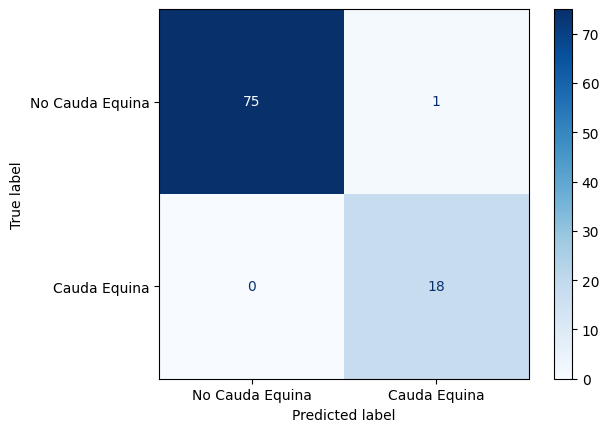

In [31]:
zephyr_2step_ce_train = eval_global(
    'zephyr', 
    'base-base-cauda-equina-train', 
    'april2024/summary-query/base-base/zephyr_base_2step_cauda_equina_train_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.9961802902979373
EER threshold: 1.57228914758889e-05
EER: 0.06493506493506493
Balanced accuracy: 0.9411764705882353
F1 score: 0.9375
                 precision    recall  f1-score   support

No Cauda Equina       0.97      1.00      0.99        77
   Cauda Equina       1.00      0.88      0.94        17

       accuracy                           0.98        94
      macro avg       0.99      0.94      0.96        94
   weighted avg       0.98      0.98      0.98        94



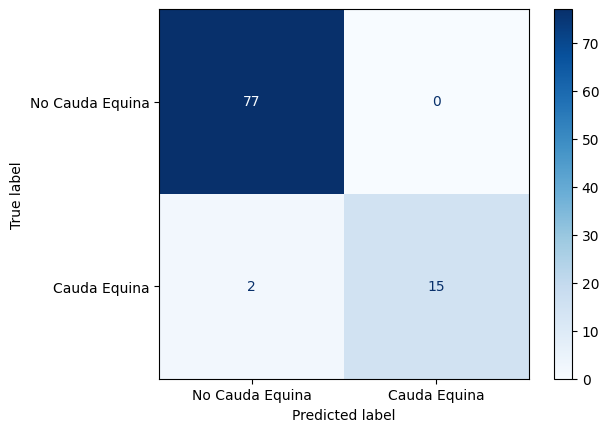

In [32]:
zephyr_2step_ce_test = eval_global(
    'zephyr', 
    'base-base-cauda-equina-test', 
    'april2024/summary-query/base-base/zephyr_base_2step_cauda_equina_test_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.9955007433891296
    )

ROC AUC: 0.733843537414966
EER threshold: 1.0
EER: 0.47619047619047616
Balanced accuracy: 0.7321428571428572
F1 score: 0.7105263157894737
               precision    recall  f1-score   support

No Herniation       0.95      0.50      0.66        42
   Herniation       0.56      0.96      0.71        28

     accuracy                           0.69        70
    macro avg       0.76      0.73      0.68        70
 weighted avg       0.80      0.69      0.68        70



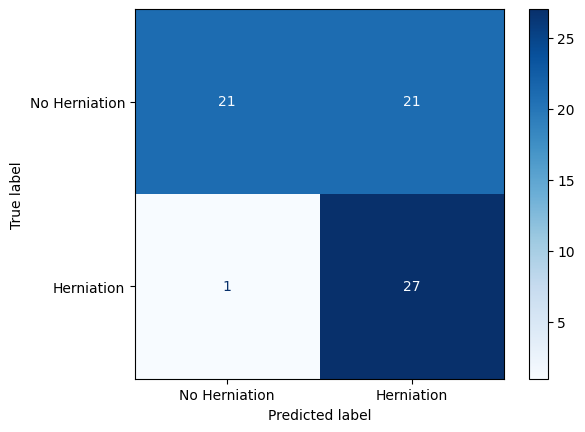

In [33]:
zephyr_2step_hern_train = eval_global(
    'zephyr', 
    'base-base-hern-train',
    'april2024/summary-query/base-base/zephyr_base_2step_herniation_train_new_template_yesno_scores_have_spec_summary_prompt'
    )

ROC AUC: 0.8039965986394558
EER threshold: 1.0
EER: 0.35714285714285715
Balanced accuracy: 0.7857142857142858
F1 score: 0.7536231884057972
               precision    recall  f1-score   support

No Herniation       0.93      0.64      0.76        42
   Herniation       0.63      0.93      0.75        28

     accuracy                           0.76        70
    macro avg       0.78      0.79      0.76        70
 weighted avg       0.81      0.76      0.76        70



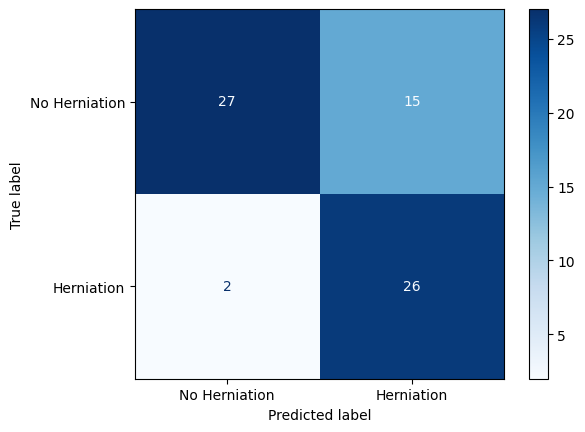

In [34]:
zephyr_2step_hern_train = eval_global(
    'zephyr', 
    'base-base-hern-test',
    'april2024/summary-query/base-base/zephyr_base_2step_herniation_test_new_template_yesno_scores_have_spec_summary_prompt',
    threshold=0.99999999
    )

#### Two-Step Query: Llama3

ROC AUC: 0.9981598855039868
EER threshold: 0.9301171898841858
EER: 0.0
Balanced accuracy: 0.9856879983643426
F1 score: 0.9850746268656716
              precision    recall  f1-score   support

   No Cancer       0.99      0.99      0.99        73
      Cancer       0.99      0.99      0.99        67

    accuracy                           0.99       140
   macro avg       0.99      0.99      0.99       140
weighted avg       0.99      0.99      0.99       140



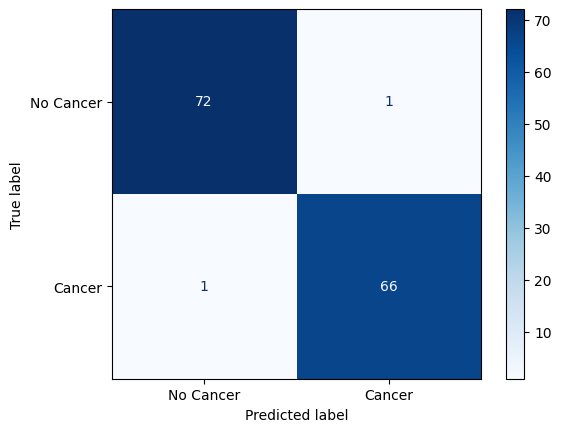

In [35]:
llama3_2step_cancer_train = eval_global(
    'llama3', 
    'base-base-cancer-train', 
    'april2024/summary-query/base-base/llama3_base_2step_cancer_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 1.0
EER threshold: 0.9747883081436157
EER: 0.0
Balanced accuracy: 1.0
F1 score: 1.0
              precision    recall  f1-score   support

   No Cancer       1.00      1.00      1.00        78
      Cancer       1.00      1.00      1.00        67

    accuracy                           1.00       145
   macro avg       1.00      1.00      1.00       145
weighted avg       1.00      1.00      1.00       145



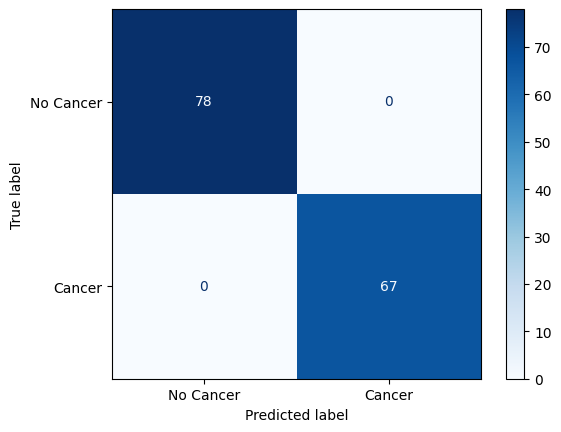

In [36]:
llama3_2step_cancer_test = eval_global(
    'llama3', 
    'base-base-cancer-test', 
    'april2024/summary-query/base-base/llama3_base_2step_cancer_TRAIN_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.9301171898841858
    )

ROC AUC: 0.9739130434782608
EER threshold: 0.9582239985466003
EER: 0.08695652173913043
Balanced accuracy: 0.8908212560386474
F1 score: 0.9347826086956522
              precision    recall  f1-score   support

 No Stenosis       0.90      0.83      0.86        23
    Stenosis       0.91      0.96      0.93        45

    accuracy                           0.91        68
   macro avg       0.91      0.89      0.90        68
weighted avg       0.91      0.91      0.91        68



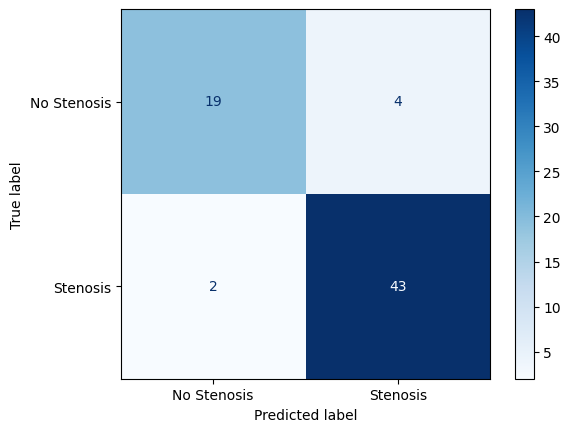

In [37]:
llama3_2step_stenosis_train = eval_global(
    'llama3', 
    'base-base-stenosis-train', 
    'april2024/summary-query/base-base/llama3_base_2step_stenosis_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.994579945799458
EER threshold: 0.8642050623893738
EER: 0.037037037037037035
Balanced accuracy: 0.9448961156278229
F1 score: 0.9500000000000001
              precision    recall  f1-score   support

 No Stenosis       0.90      0.96      0.93        27
    Stenosis       0.97      0.93      0.95        41

    accuracy                           0.94        68
   macro avg       0.94      0.94      0.94        68
weighted avg       0.94      0.94      0.94        68



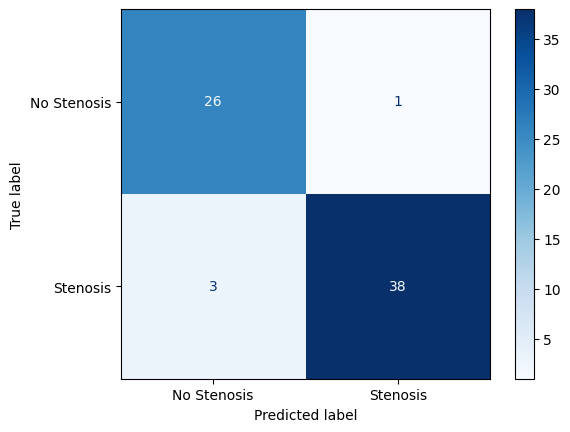

In [38]:
llama3_2step_stenosis_test = eval_global(
    'llama3', 
    'base-base-stenosis-test', 
    'april2024/summary-query/base-base/llama3_base_2step_stenosis_TRAIN_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.9582239985466003
    )

ROC AUC: 0.9897660818713451
EER threshold: 0.999830961227417
EER: 0.013157894736842105
Balanced accuracy: 0.9671052631578947
F1 score: 0.878048780487805
                 precision    recall  f1-score   support

No Cauda Equina       1.00      0.93      0.97        76
   Cauda Equina       0.78      1.00      0.88        18

       accuracy                           0.95        94
      macro avg       0.89      0.97      0.92        94
   weighted avg       0.96      0.95      0.95        94



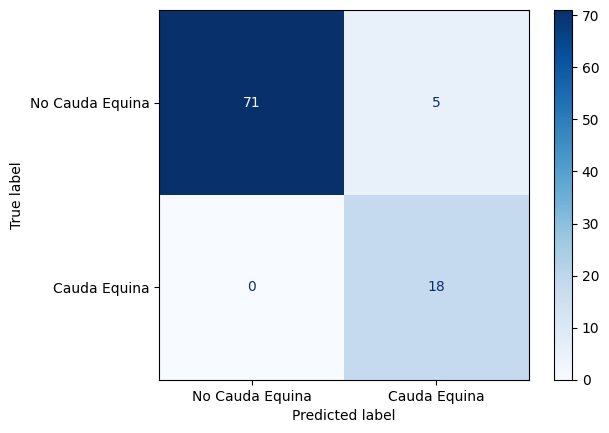

In [39]:
llama3_2step_ce_train_2step_ce_train = eval_global(
    'llama3', 
    'base-base-cauda-equina-train',
    'april2024/summary-query/base-base/llama3_base_2step_cauda_equina_train_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.998472116119175
EER threshold: 0.9991982579231262
EER: 0.025974025974025976
Balanced accuracy: 0.9705882352941176
F1 score: 0.9696969696969697
                 precision    recall  f1-score   support

No Cauda Equina       0.99      1.00      0.99        77
   Cauda Equina       1.00      0.94      0.97        17

       accuracy                           0.99        94
      macro avg       0.99      0.97      0.98        94
   weighted avg       0.99      0.99      0.99        94



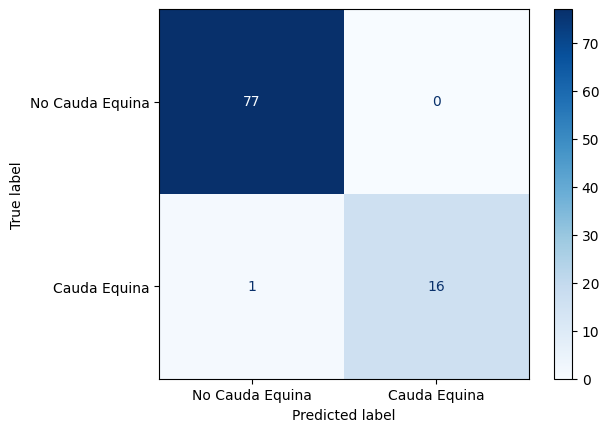

In [40]:
llama3_2step_ce_train_2step_ce_test = eval_global(
    'llama3', 
    'base-base-cauda-equina-test',
    'april2024/summary-query/base-base/llama3_base_2step_cauda_equina_test_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.999830961227417
    )

ROC AUC: 0.8958333333333334
EER threshold: 0.9999567270278931
EER: 0.19047619047619047
Balanced accuracy: 0.6428571428571428
F1 score: 0.6511627906976745
               precision    recall  f1-score   support

No Herniation       1.00      0.29      0.44        42
   Herniation       0.48      1.00      0.65        28

     accuracy                           0.57        70
    macro avg       0.74      0.64      0.55        70
 weighted avg       0.79      0.57      0.53        70



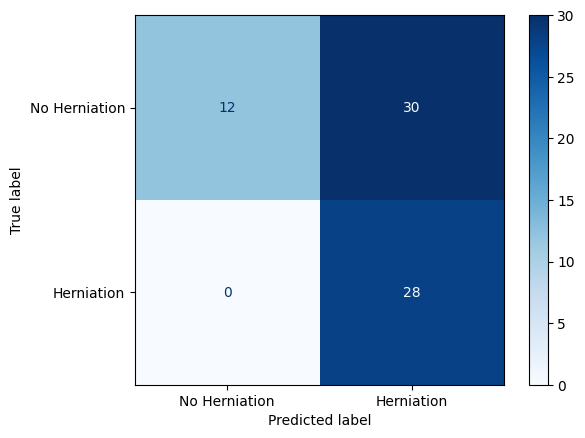

In [41]:
llama3_2step_hern_train = eval_global(
    'llama3', 
    'base-base-hern-train',
    'april2024/summary-query/base-base/llama3_base_2step_herniation_train_new_template_yesno_scores_have_spec_summary_prompt'
    )

ROC AUC: 0.933248299319728
EER threshold: 0.9999233484268188
EER: 0.11904761904761904
Balanced accuracy: 0.8571428571428572
F1 score: 0.830188679245283
               precision    recall  f1-score   support

No Herniation       0.87      0.93      0.90        42
   Herniation       0.88      0.79      0.83        28

     accuracy                           0.87        70
    macro avg       0.87      0.86      0.86        70
 weighted avg       0.87      0.87      0.87        70



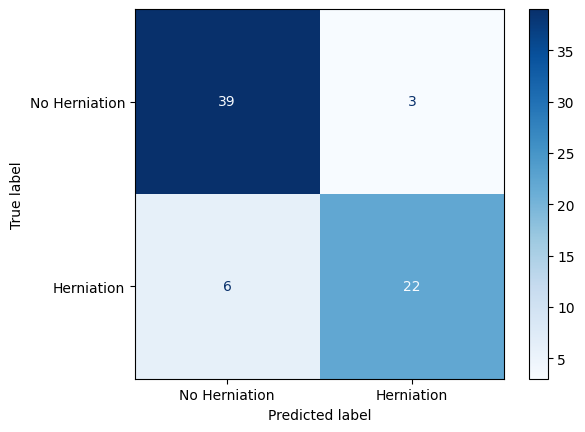

In [42]:
llama3_2step_hern_test = eval_global(
    'llama3', 
    'base-base-hern-test',
    'april2024/summary-query/base-base/llama3_base_2step_herniation_test_new_template_yesno_scores_have_spec_summary_prompt',
    threshold=0.9999567270278931
    )

### Two-Step Query: Lora NTP Summary + Zephyr Query

ROC AUC: 0.9971375996728686
EER threshold: 5.927645543124527e-05
EER: 0.0273972602739726
Balanced accuracy: 0.9707626252300143
F1 score: 0.9696969696969696
              precision    recall  f1-score   support

   No Cancer       0.96      0.99      0.97        73
      Cancer       0.98      0.96      0.97        67

    accuracy                           0.97       140
   macro avg       0.97      0.97      0.97       140
weighted avg       0.97      0.97      0.97       140



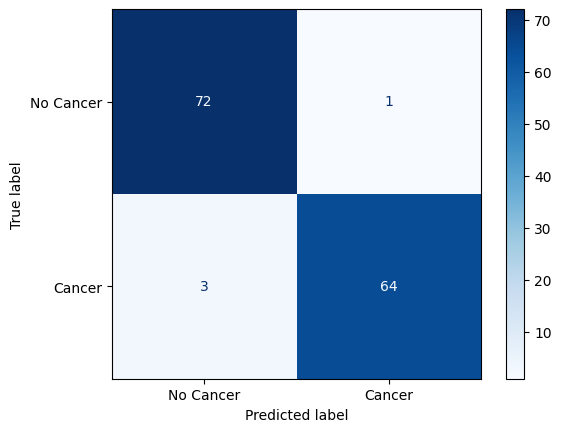

In [43]:
ntp_base_2step_cancer_train = eval_global(
    'ntp+zephyr', 
    'sft-base-cancer-train', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_cancer_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 1.0
EER threshold: 0.04961172491312027
EER: 0.0
Balanced accuracy: 0.9935897435897436
F1 score: 0.9925925925925926
              precision    recall  f1-score   support

   No Cancer       1.00      0.99      0.99        78
      Cancer       0.99      1.00      0.99        67

    accuracy                           0.99       145
   macro avg       0.99      0.99      0.99       145
weighted avg       0.99      0.99      0.99       145



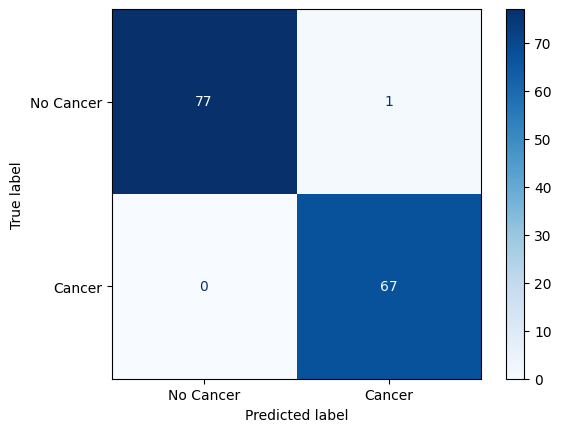

In [44]:
ntp_base_2step_cancer_test = eval_global(
    'ntp+zephyr', 
    'sft-base-cancer-test', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_cancer_TRAIN_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=5.927645543124527e-05
    )

ROC AUC: 0.9536231884057972
EER threshold: 0.00011538965190993622
EER: 0.043478260869565216
Balanced accuracy: 0.7
F1 score: 0.5714285714285715
              precision    recall  f1-score   support

 No Stenosis       0.46      1.00      0.63        23
    Stenosis       1.00      0.40      0.57        45

    accuracy                           0.60        68
   macro avg       0.73      0.70      0.60        68
weighted avg       0.82      0.60      0.59        68



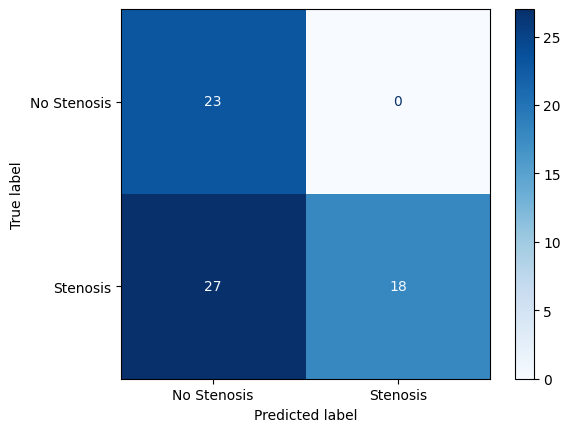

In [45]:
ntp_base_2step_stenosis_train = eval_global(
    'ntp+zephyr', 
    'sft-base-stenosis-train', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_stenosis_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.9430894308943089
EER threshold: 0.00011272726987954229
EER: 0.037037037037037035
Balanced accuracy: 0.9327009936766034
F1 score: 0.9367088607594938
              precision    recall  f1-score   support

 No Stenosis       0.87      0.96      0.91        27
    Stenosis       0.97      0.90      0.94        41

    accuracy                           0.93        68
   macro avg       0.92      0.93      0.92        68
weighted avg       0.93      0.93      0.93        68



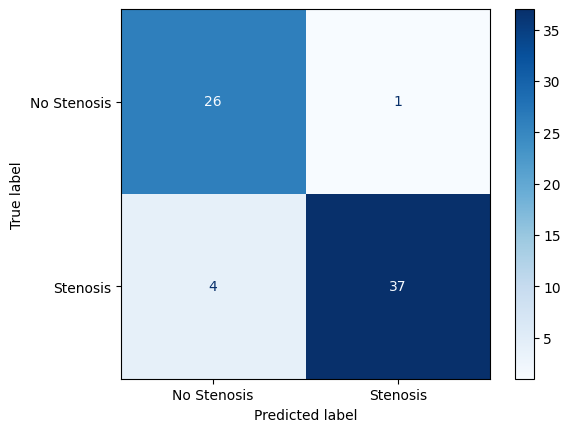

In [46]:
ntp_base_2step_stenosis_test = eval_global(
    'ntp+zephyr', 
    'sft-base-stenosis-test', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_stenosis_TRAIN_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.00011538965190993622
    )

ROC AUC: 0.9956140350877193
EER threshold: 0.998689591884613
EER: 0.013157894736842105
Balanced accuracy: 0.993421052631579
F1 score: 0.972972972972973
                 precision    recall  f1-score   support

No Cauda Equina       1.00      0.99      0.99        76
   Cauda Equina       0.95      1.00      0.97        18

       accuracy                           0.99        94
      macro avg       0.97      0.99      0.98        94
   weighted avg       0.99      0.99      0.99        94



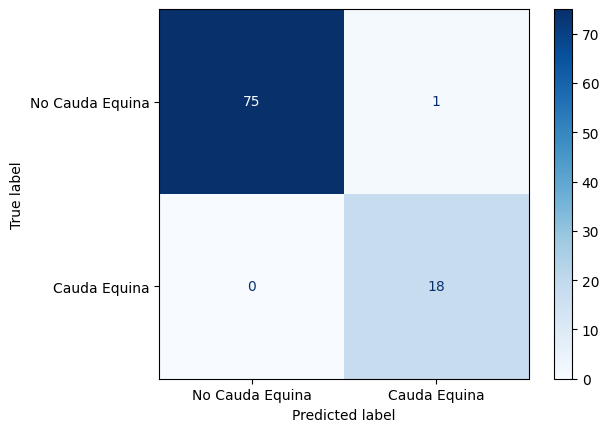

In [47]:
ntp_base_2step_ce_train = eval_global(
    'ntp+zephyr', 
    'sft-base-cauda-equina-train', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_cauda_equina_train_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.998472116119175
EER threshold: 2.9858530979254283e-05
EER: 0.025974025974025976
Balanced accuracy: 0.7647058823529411
F1 score: 0.6923076923076924
                 precision    recall  f1-score   support

No Cauda Equina       0.91      1.00      0.95        77
   Cauda Equina       1.00      0.53      0.69        17

       accuracy                           0.91        94
      macro avg       0.95      0.76      0.82        94
   weighted avg       0.92      0.91      0.90        94



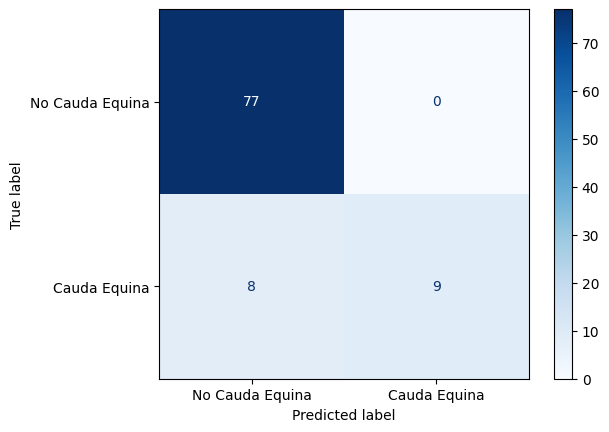

In [48]:
ntp_base_2step_ce_test = eval_global(
    'ntp+zephyr', 
    'sft-base-cauda-equina-test', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_cauda_equina_test_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.998689591884613
    )

ROC AUC: 0.7874149659863946
EER threshold: 0.0006265001720748842
EER: 0.2857142857142857
Balanced accuracy: 0.6428571428571429
F1 score: 0.48780487804878053
               precision    recall  f1-score   support

No Herniation       0.68      0.93      0.79        42
   Herniation       0.77      0.36      0.49        28

     accuracy                           0.70        70
    macro avg       0.73      0.64      0.64        70
 weighted avg       0.72      0.70      0.67        70



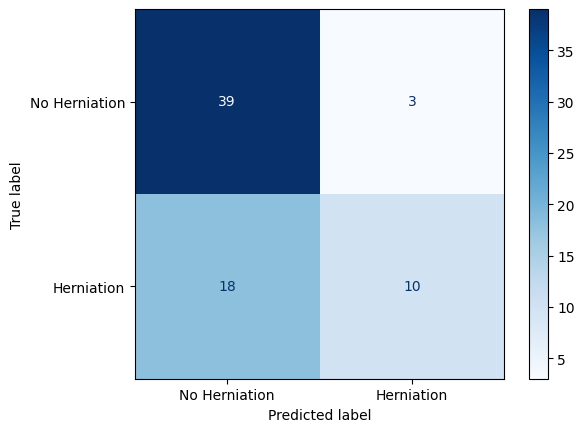

In [49]:
ntp_base_2step_hern_train = eval_global(
    'ntp+zephyr', 
    'sft-base-hern-train', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_herniation_train_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.9039115646258503
EER threshold: 0.0003103855124209076
EER: 0.21428571428571427
Balanced accuracy: 0.8095238095238095
F1 score: 0.7719298245614034
               precision    recall  f1-score   support

No Herniation       0.85      0.83      0.84        42
   Herniation       0.76      0.79      0.77        28

     accuracy                           0.81        70
    macro avg       0.81      0.81      0.81        70
 weighted avg       0.82      0.81      0.81        70



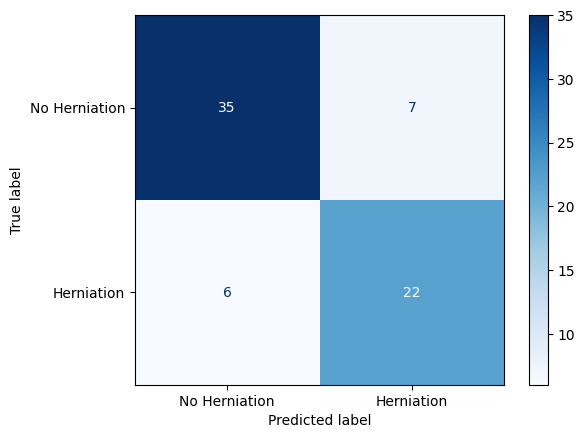

In [50]:
ntp_base_2step_hern_test = eval_global(
    'ntp+zephyr', 
    'sft-base-hern-test', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_herniation_test_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.0006265001720748842
    )

#### Llama3

ROC AUC: 0.998773257002658
EER threshold: 0.6921234130859375
EER: 0.0273972602739726
Balanced accuracy: 0.9726027397260274
F1 score: 0.9710144927536231
              precision    recall  f1-score   support

   No Cancer       1.00      0.95      0.97        73
      Cancer       0.94      1.00      0.97        67

    accuracy                           0.97       140
   macro avg       0.97      0.97      0.97       140
weighted avg       0.97      0.97      0.97       140



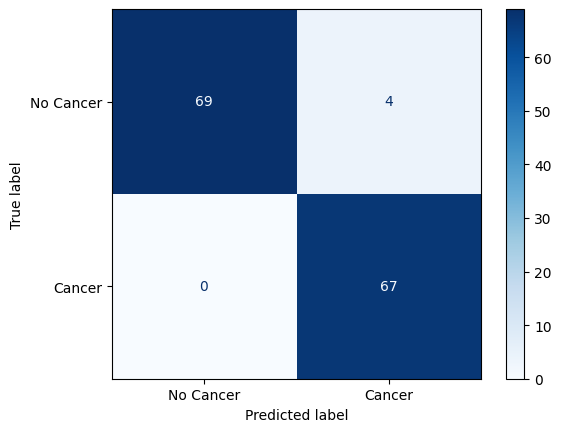

In [51]:
llama3_ntp_base_2step_cancer_train = eval_global(
    'ntp+llama3', 
    'sft-base-cancer-train', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_cancer_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.9910065059318791
EER threshold: 0.9101793766021729
EER: 0.01282051282051282
Balanced accuracy: 0.9722541140451588
F1 score: 0.9701492537313433
              precision    recall  f1-score   support

   No Cancer       0.97      0.97      0.97        78
      Cancer       0.97      0.97      0.97        67

    accuracy                           0.97       145
   macro avg       0.97      0.97      0.97       145
weighted avg       0.97      0.97      0.97       145



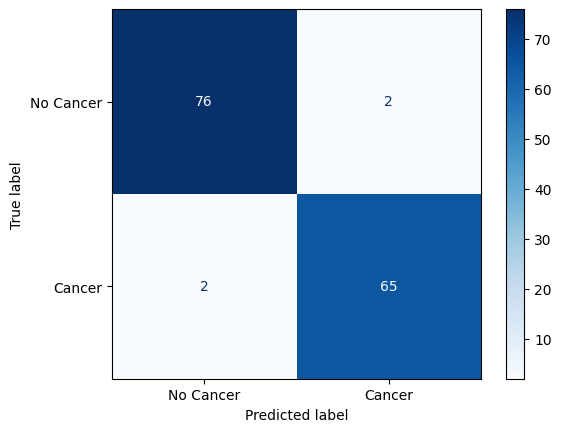

In [52]:
llama3_ntp_base_2step_cancer_test = eval_global(
    'ntp+llama3', 
    'sft-base-cancer-test', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_cancer_TRAIN_new_template_yesno_scores_have_spec_summary_prompt',
    threshold=0.6921234130859375
    )

ROC AUC: 0.8502415458937198
EER threshold: 0.9492835402488708
EER: 0.21739130434782608
Balanced accuracy: 0.7705314009661836
F1 score: 0.8602150537634408
              precision    recall  f1-score   support

 No Stenosis       0.75      0.65      0.70        23
    Stenosis       0.83      0.89      0.86        45

    accuracy                           0.81        68
   macro avg       0.79      0.77      0.78        68
weighted avg       0.81      0.81      0.81        68



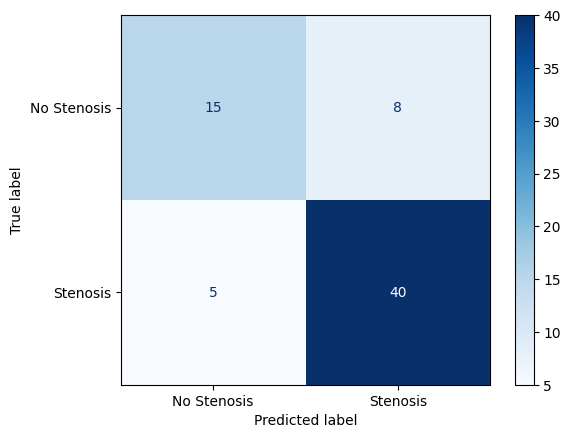

In [53]:
llama3_ntp_base_2step_stenosis_train = eval_global(
    'ntp+llama3', 
    'sft-base-stenosis-train', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_stenosis_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.8979223125564588
EER threshold: 0.9686349034309387
EER: 0.18518518518518517
Balanced accuracy: 0.8401084010840109
F1 score: 0.8809523809523809
              precision    recall  f1-score   support

 No Stenosis       0.84      0.78      0.81        27
    Stenosis       0.86      0.90      0.88        41

    accuracy                           0.85        68
   macro avg       0.85      0.84      0.84        68
weighted avg       0.85      0.85      0.85        68



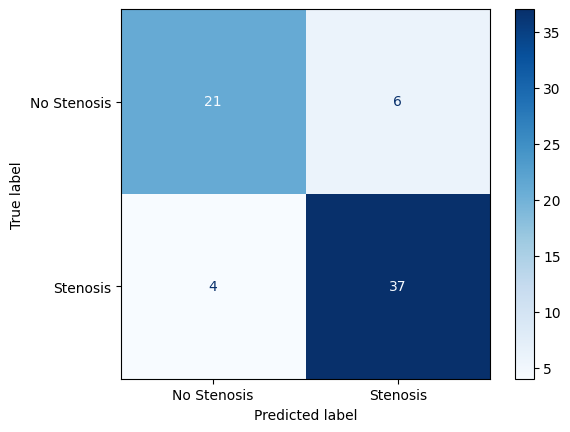

In [54]:
llama3_ntp_base_2step_stenosis_test = eval_global(
    'ntp+llama3', 
    'sft-base-stenosis-test', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_stenosis_TRAIN_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.9492835402488708
    )

ROC AUC: 0.9809941520467836
EER threshold: 0.88526451587677
EER: 0.039473684210526314
Balanced accuracy: 0.9802631578947368
F1 score: 0.923076923076923
                 precision    recall  f1-score   support

No Cauda Equina       1.00      0.96      0.98        76
   Cauda Equina       0.86      1.00      0.92        18

       accuracy                           0.97        94
      macro avg       0.93      0.98      0.95        94
   weighted avg       0.97      0.97      0.97        94



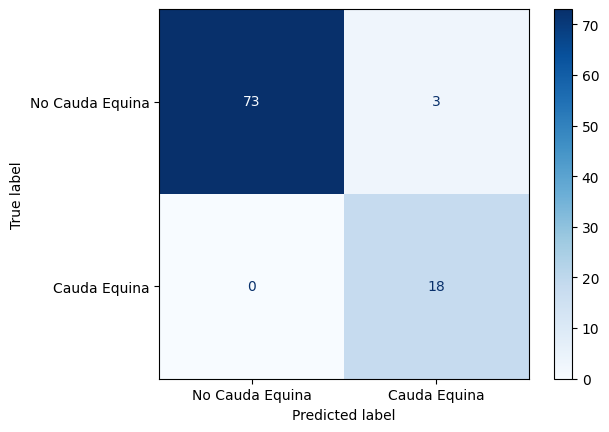

In [55]:
llama3_ntp_base_2step_ce_train = eval_global(
    'ntp+llama3', 
    'sft-base-cauda-equina-train', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_cauda_equina_train_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.9862490450725745
EER threshold: 0.5624486804008484
EER: 0.03896103896103896
Balanced accuracy: 0.8922841864018334
F1 score: 0.8235294117647058
                 precision    recall  f1-score   support

No Cauda Equina       0.96      0.96      0.96        77
   Cauda Equina       0.82      0.82      0.82        17

       accuracy                           0.94        94
      macro avg       0.89      0.89      0.89        94
   weighted avg       0.94      0.94      0.94        94



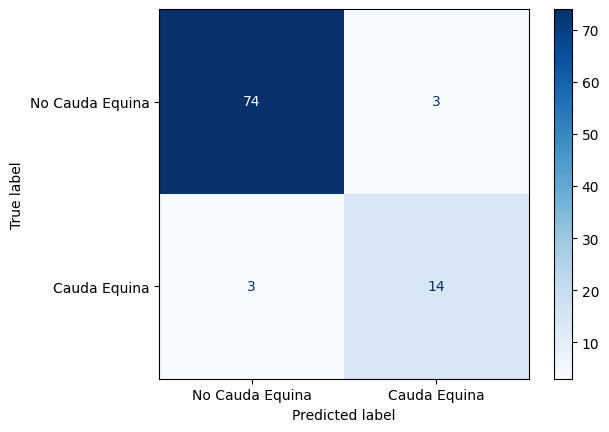

In [56]:
llama3_ntp_base_2step_ce_test = eval_global(
    'ntp+llama3', 
    'sft-base-cauda-equina-test', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_cauda_equina_test_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.88526451587677
    )

ROC AUC: 0.6904761904761906
EER threshold: 0.20162710547447205
EER: 0.35714285714285715
Balanced accuracy: 0.6309523809523809
F1 score: 0.5106382978723404
               precision    recall  f1-score   support

No Herniation       0.69      0.83      0.75        42
   Herniation       0.63      0.43      0.51        28

     accuracy                           0.67        70
    macro avg       0.66      0.63      0.63        70
 weighted avg       0.66      0.67      0.66        70



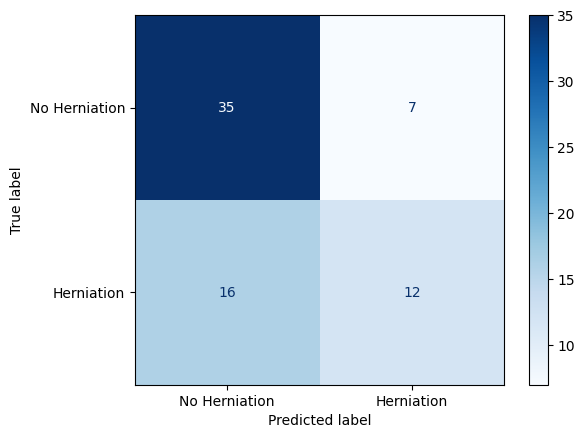

In [57]:
llama3_ntp_base_2step_hern_train = eval_global(
    'ntp+llama3', 
    'sft-base-hern-train', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_herniation_train_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.7933673469387755
EER threshold: 0.14691248536109924
EER: 0.2619047619047619
Balanced accuracy: 0.7202380952380952
F1 score: 0.6538461538461539
               precision    recall  f1-score   support

No Herniation       0.76      0.83      0.80        42
   Herniation       0.71      0.61      0.65        28

     accuracy                           0.74        70
    macro avg       0.73      0.72      0.72        70
 weighted avg       0.74      0.74      0.74        70



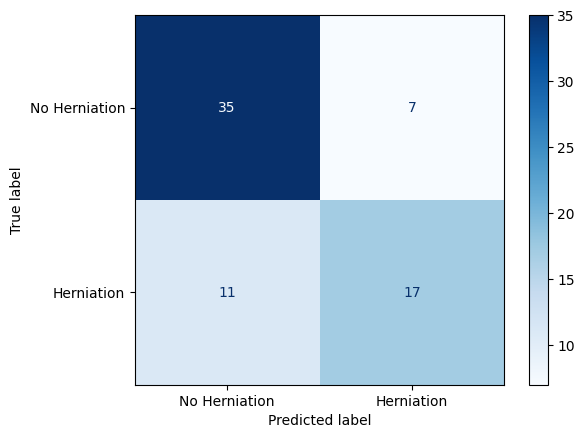

In [58]:
llama3_ntp_base_2step_hern_test = eval_global(
    'ntp+llama3', 
    'sft-base-hern-test', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_herniation_test_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.20162710547447205
    )

In [59]:
df_results = pd.DataFrame(li_results)

In [60]:
df_results_cancer = df_results.loc[df_results.desc.str.find('cancer') > -1]
df_results_cancer

,model,desc,balanced_accuracy,eer,auroc,f1_score
0,gpt4,direct-query-cancer-test,1.000000,-,-,1.000000
4,zephyr,direct-query-cancer-test,0.992537,0.0,1.0,0.992481
8,llama3,direct-query-cancer-test,0.978225,0.013699,0.998773,0.977444
12,zephyr,base-base-cancer-test,0.985075,0.0,1.0,0.984848
16,llama3,base-base-cancer-test,1.000000,0.0,1.0,1.000000
20,ntp+zephyr,sft-base-cancer-test,0.993590,0.0,1.0,0.992593
24,ntp+llama3,sft-base-cancer-test,0.972254,0.012821,0.991007,0.970149


In [61]:
df_results_stenosis = df_results.loc[df_results.desc.str.find('stenosis') > -1]
df_results_stenosis

,model,desc,balanced_accuracy,eer,auroc,f1_score
1,gpt4,direct-query-stenosis-test,0.951220,-,-,0.948718
5,zephyr,direct-query-stenosis-test,0.944896,0.037037,0.98103,0.950000
9,llama3,direct-query-stenosis-test,0.963415,0.0,0.987353,0.962025
13,zephyr,base-base-stenosis-test,0.944896,0.111111,0.984643,0.950000
17,llama3,base-base-stenosis-test,0.944896,0.037037,0.99458,0.950000
21,ntp+zephyr,sft-base-stenosis-test,0.932701,0.037037,0.943089,0.936709
25,ntp+llama3,sft-base-stenosis-test,0.840108,0.185185,0.897922,0.880952


In [62]:
df_results_cauda = df_results.loc[df_results.desc.str.find('cauda') > -1]
df_results_cauda

,model,desc,balanced_accuracy,eer,auroc,f1_score
2,gpt4,direct-query-cauda-equina-test,0.970588,-,-,0.969697
6,zephyr,direct-query-cauda-equina-test,0.941176,0.038961,0.997708,0.937500
10,llama3,direct-query-cauda-equina-test,0.970588,0.025974,0.998472,0.969697
14,zephyr,base-base-cauda-equina-test,0.941176,0.064935,0.99618,0.937500
18,llama3,base-base-cauda-equina-test,0.970588,0.025974,0.998472,0.969697
22,ntp+zephyr,sft-base-cauda-equina-test,0.764706,0.025974,0.998472,0.692308
26,ntp+llama3,sft-base-cauda-equina-test,0.892284,0.038961,0.986249,0.823529


In [63]:
df_results_hern = df_results.loc[df_results.desc.str.find('hern') > -1]
df_results_hern

,model,desc,balanced_accuracy,eer,auroc,f1_score
3,gpt4,direct-query-herniation-test,0.714286,-,-,0.700000
7,zephyr,direct-query-hern-test,0.851190,0.119048,0.92432,0.821429
11,llama3,direct-query-hern-test,0.880952,0.095238,0.937075,0.857143
15,zephyr,base-base-hern-test,0.785714,0.357143,0.803997,0.753623
19,llama3,base-base-hern-test,0.857143,0.119048,0.933248,0.830189
23,ntp+zephyr,sft-base-hern-test,0.809524,0.214286,0.903912,0.771930
27,ntp+llama3,sft-base-hern-test,0.720238,0.261905,0.793367,0.653846


## IVD-Level Results for Stenosis

ROC AUC: 0.9342560553633219
Balanced accuracy: 0.9019607843137254
F1 score: 0.8333333333333333
EER threshold: 0.5957925319671631
EER: 0.0784313725490196
              precision    recall  f1-score   support

 No Stenosis       0.96      0.92      0.94        51
    Stenosis       0.79      0.88      0.83        17

    accuracy                           0.91        68
   macro avg       0.87      0.90      0.89        68
weighted avg       0.92      0.91      0.91        68



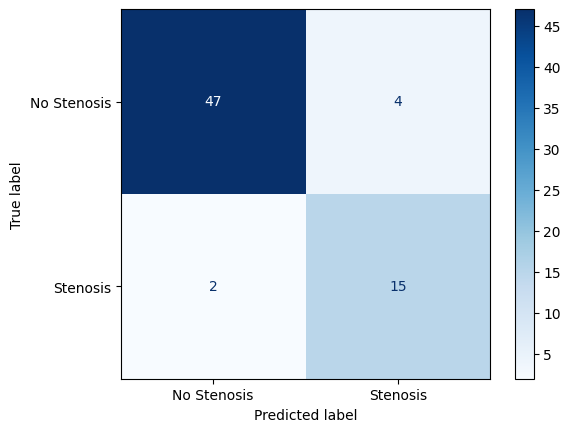

In [64]:
llama_base_2step_stenosis_l3l4_train = eval_level('stenosis', 'L3-L4', threshold=None)

ROC AUC: 0.9678321678321679
Balanced accuracy: 0.8958041958041958
F1 score: 0.8148148148148148
EER threshold: 0.45438912510871887
EER: 0.07272727272727272
              precision    recall  f1-score   support

 No Stenosis       0.96      0.95      0.95        55
    Stenosis       0.79      0.85      0.81        13

    accuracy                           0.93        68
   macro avg       0.87      0.90      0.88        68
weighted avg       0.93      0.93      0.93        68



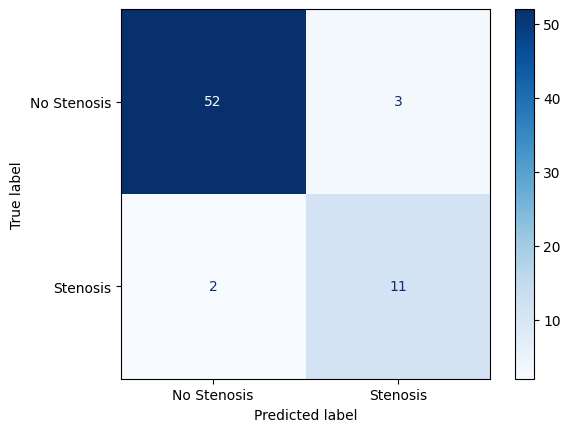

In [65]:
llama_base_2step_stenosis_l3l4_test = eval_level('stenosis_TRAIN', 'L3-L4', threshold=0.5957925319671631)

ROC AUC: 0.9017543859649122
Balanced accuracy: 0.8017543859649123
F1 score: 0.7878787878787877
EER threshold: 0.9059188365936279
EER: 0.18421052631578946
              precision    recall  f1-score   support

 No Stenosis       0.88      0.74      0.80        38
    Stenosis       0.72      0.87      0.79        30

    accuracy                           0.79        68
   macro avg       0.80      0.80      0.79        68
weighted avg       0.81      0.79      0.79        68



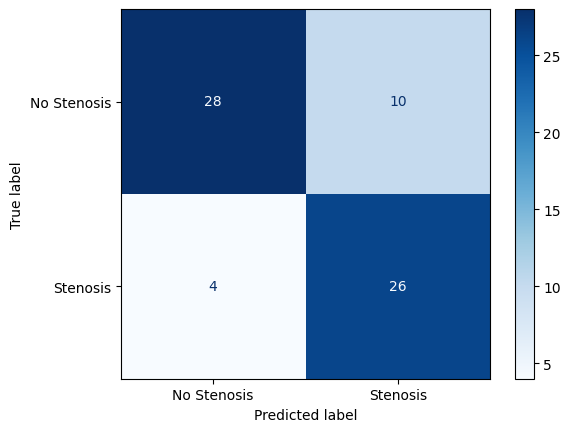

In [66]:
llama_base_2step_stenosis_l4l5_train = eval_level('stenosis', 'L4-L5', threshold=None)

ROC AUC: 0.9782040104620751
Balanced accuracy: 0.9084568439407149
F1 score: 0.9
EER threshold: 0.6253496408462524
EER: 0.10810810810810811
              precision    recall  f1-score   support

 No Stenosis       0.90      0.95      0.92        37
    Stenosis       0.93      0.87      0.90        31

    accuracy                           0.91        68
   macro avg       0.91      0.91      0.91        68
weighted avg       0.91      0.91      0.91        68



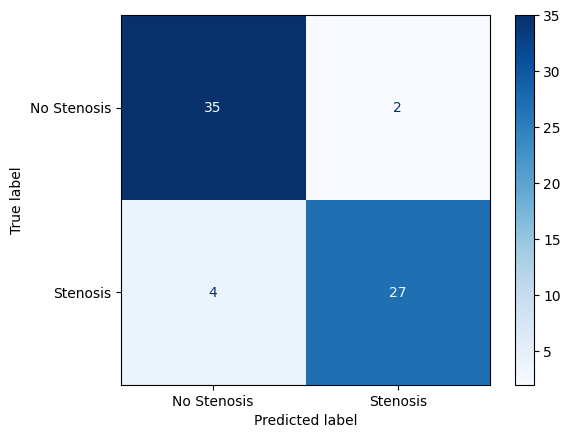

In [67]:
llama_base_2step_stenosis_l4l5_test = eval_level('stenosis_TRAIN', 'L4-L5', threshold=0.9059188365936279)

ROC AUC: 0.9596491228070176
Balanced accuracy: 0.8614035087719298
F1 score: 0.8484848484848485
EER threshold: 0.8589565753936768
EER: 0.07894736842105263
              precision    recall  f1-score   support

 No Stenosis       0.94      0.79      0.86        38
    Stenosis       0.78      0.93      0.85        30

    accuracy                           0.85        68
   macro avg       0.86      0.86      0.85        68
weighted avg       0.87      0.85      0.85        68



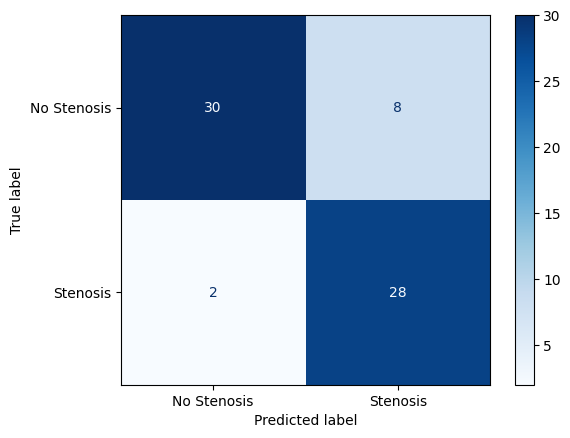

In [68]:
llama_base_2step_stenosis_l5s1_train = eval_level('stenosis', 'L5-S1', threshold=None)

ROC AUC: 0.9446428571428571
Balanced accuracy: 0.8553571428571429
F1 score: 0.830188679245283
EER threshold: 0.33229073882102966
EER: 0.15
              precision    recall  f1-score   support

 No Stenosis       0.86      0.93      0.89        40
    Stenosis       0.88      0.79      0.83        28

    accuracy                           0.87        68
   macro avg       0.87      0.86      0.86        68
weighted avg       0.87      0.87      0.87        68



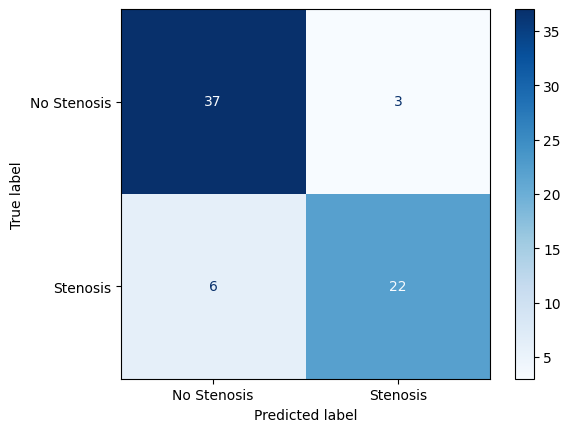

In [69]:
llama_base_2step_stenosis_l5s1_test = eval_level('stenosis_TRAIN', 'L5-S1', threshold=0.8589565753936768)

In [70]:
df_level_results = pd.DataFrame(li_level_results)
df_level_results

,condition,level,balanced_accuracy,eer,auroc,f1_score
0,stenosis,L3-L4,0.895804,0.072727,0.967832,0.814815
1,stenosis,L4-L5,0.908457,0.108108,0.978204,0.900000
2,stenosis,L5-S1,0.855357,0.150000,0.944643,0.830189


### Herniation by Level

ROC AUC: 0.9949494949494949
Balanced accuracy: 0.9318181818181819
F1 score: 0.4
EER threshold: 0.9994730353355408
EER: 0.015151515151515152
              precision    recall  f1-score   support

 No Stenosis       1.00      0.86      0.93        66
    Stenosis       0.25      1.00      0.40         3

    accuracy                           0.87        69
   macro avg       0.62      0.93      0.66        69
weighted avg       0.97      0.87      0.90        69



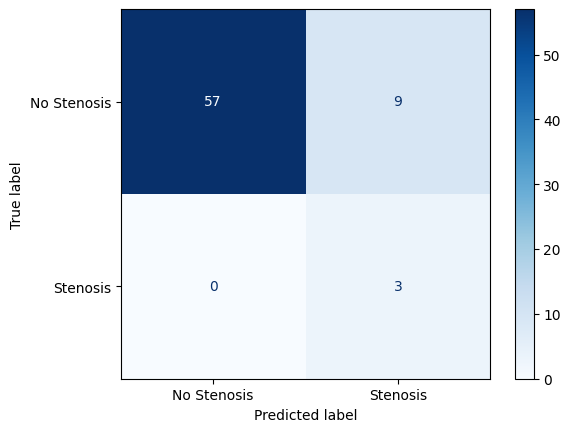

In [71]:
llama_base_2step_hern_l3l4_train = eval_level('herniation_train', 'L3-L4', threshold=None)

ROC AUC: 0.9384615384615385
Balanced accuracy: 0.7923076923076924
F1 score: 0.6666666666666665
EER threshold: 0.30039191246032715
EER: 0.2
              precision    recall  f1-score   support

 No Stenosis       0.97      0.98      0.98        65
    Stenosis       0.75      0.60      0.67         5

    accuracy                           0.96        70
   macro avg       0.86      0.79      0.82        70
weighted avg       0.95      0.96      0.95        70



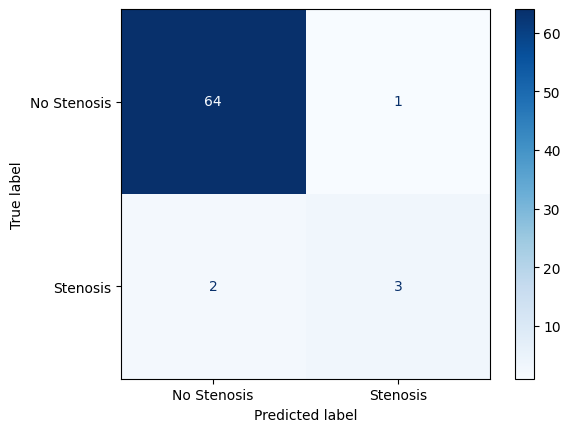

In [72]:
llama_base_2step_hern_l3l4_test = eval_level('herniation_test', 'L3-L4', threshold=0.9994730353355408)

ROC AUC: 0.9155172413793103
Balanced accuracy: 0.7672413793103448
F1 score: 0.4255319148936171
EER threshold: 0.9998561143875122
EER: 0.15517241379310345
              precision    recall  f1-score   support

 No Stenosis       1.00      0.53      0.70        58
    Stenosis       0.27      1.00      0.43        10

    accuracy                           0.60        68
   macro avg       0.64      0.77      0.56        68
weighted avg       0.89      0.60      0.66        68



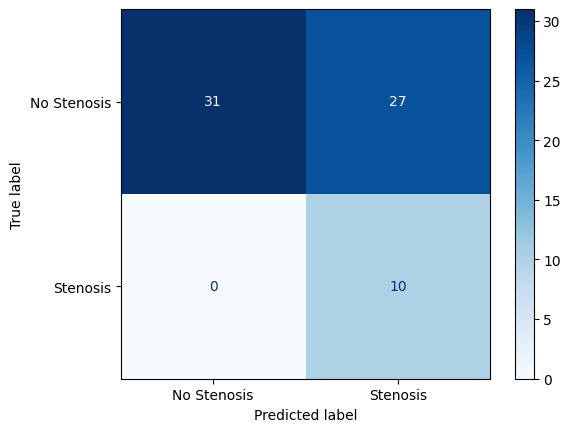

In [73]:
llama_base_2step_hern_l4l5_train = eval_level('herniation_train', 'L4-L5', threshold=None)

ROC AUC: 0.934311224489796
Balanced accuracy: 0.8839285714285714
F1 score: 0.7222222222222223
EER threshold: 0.9999204874038696
EER: 0.125
              precision    recall  f1-score   support

 No Stenosis       0.98      0.84      0.90        56
    Stenosis       0.59      0.93      0.72        14

    accuracy                           0.86        70
   macro avg       0.79      0.88      0.81        70
weighted avg       0.90      0.86      0.87        70



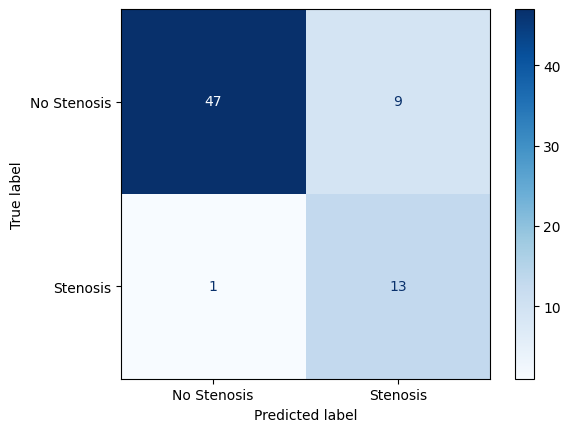

In [74]:
llama_base_2step_hern_l4l5_test = eval_level('herniation_test', 'L4-L5', threshold=0.9998561143875122)

ROC AUC: 0.9363636363636363
Balanced accuracy: 0.8181818181818181
F1 score: 0.5833333333333334
EER threshold: 0.9998112320899963
EER: 0.18181818181818182
              precision    recall  f1-score   support

 No Stenosis       1.00      0.64      0.78        55
    Stenosis       0.41      1.00      0.58        14

    accuracy                           0.71        69
   macro avg       0.71      0.82      0.68        69
weighted avg       0.88      0.71      0.74        69



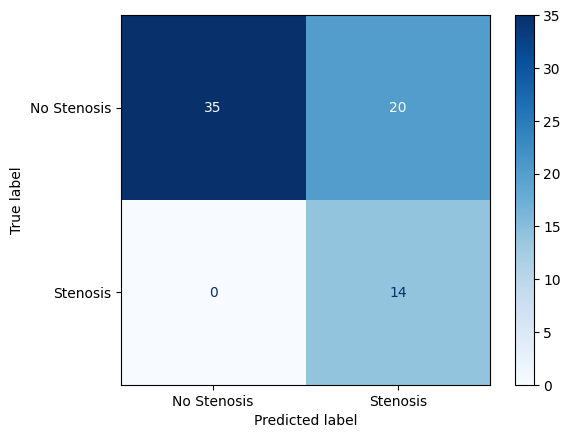

In [75]:
llama_base_2step_hern_l5s1_train = eval_level('herniation_train', 'L5-S1', threshold=None)

ROC AUC: 0.8952234206471494
Balanced accuracy: 0.8667180277349769
F1 score: 0.7200000000000001
EER threshold: 0.9998770952224731
EER: 0.0847457627118644
              precision    recall  f1-score   support

 No Stenosis       0.96      0.92      0.94        59
    Stenosis       0.64      0.82      0.72        11

    accuracy                           0.90        70
   macro avg       0.80      0.87      0.83        70
weighted avg       0.91      0.90      0.90        70



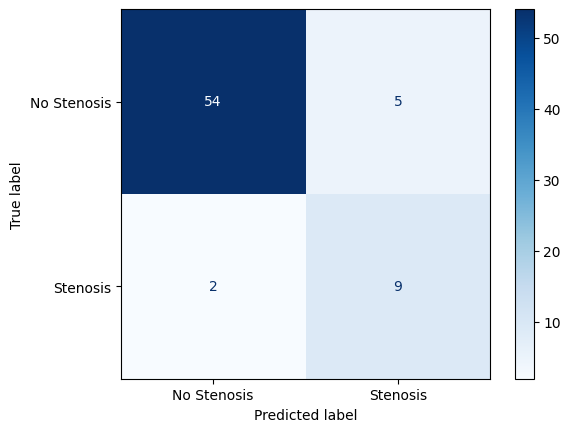

In [76]:
llama_base_2step_hern_l5s1_test = eval_level('herniation_test', 'L5-S1', threshold=0.9998112320899963)

In [77]:
df_level_results = pd.DataFrame(li_level_results)
df_level_results

,condition,level,balanced_accuracy,eer,auroc,f1_score
0,stenosis,L3-L4,0.895804,0.072727,0.967832,0.814815
1,stenosis,L4-L5,0.908457,0.108108,0.978204,0.900000
2,stenosis,L5-S1,0.855357,0.150000,0.944643,0.830189
3,herniation,L3-L4,0.792308,0.200000,0.938462,0.666667
4,herniation,L4-L5,0.883929,0.125000,0.934311,0.722222
5,herniation,L5-S1,0.866718,0.084746,0.895223,0.720000
